<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Advanced Time Series Analysis</h1>
<h1>GARCH Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import statsmodels.api as sm

import arch
from arch import arch_model

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

pandas          1.0.1
json            2.0.9
arch            4.15
watermark       2.0.2
autopep8        1.5
matplotlib      3.1.3
statsmodels.api 0.11.1
numpy           1.18.1
Wed Aug 12 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ad113ebccef84746db0546ef024c357d7cba54ca


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Simulating  ARCH Models

__time_series_plot__ and simulation code inspired by http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [4]:
def time_series_plot(y, title=None):
    fig, axs_lst = plt.subplots(3, 1)
    
    if title is not None:
        axs_lst[0].set_title(title)
    
    y.plot(ax=axs_lst[0])
    sm.tsa.graphics.plot_acf(y, ax=axs_lst[1], alpha=0.5)
    sm.tsa.graphics.plot_pacf(y, ax=axs_lst[2], alpha=0.5)

    plt.tight_layout()

In [5]:
def ARCH(a0, a1):
    y = w = np.random.normal(size=1000)
    Y = np.empty_like(y)

    for t in range(len(y)):
        Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
    
    return pd.Series(Y)

In [6]:
Y = ARCH(2, 0.5)

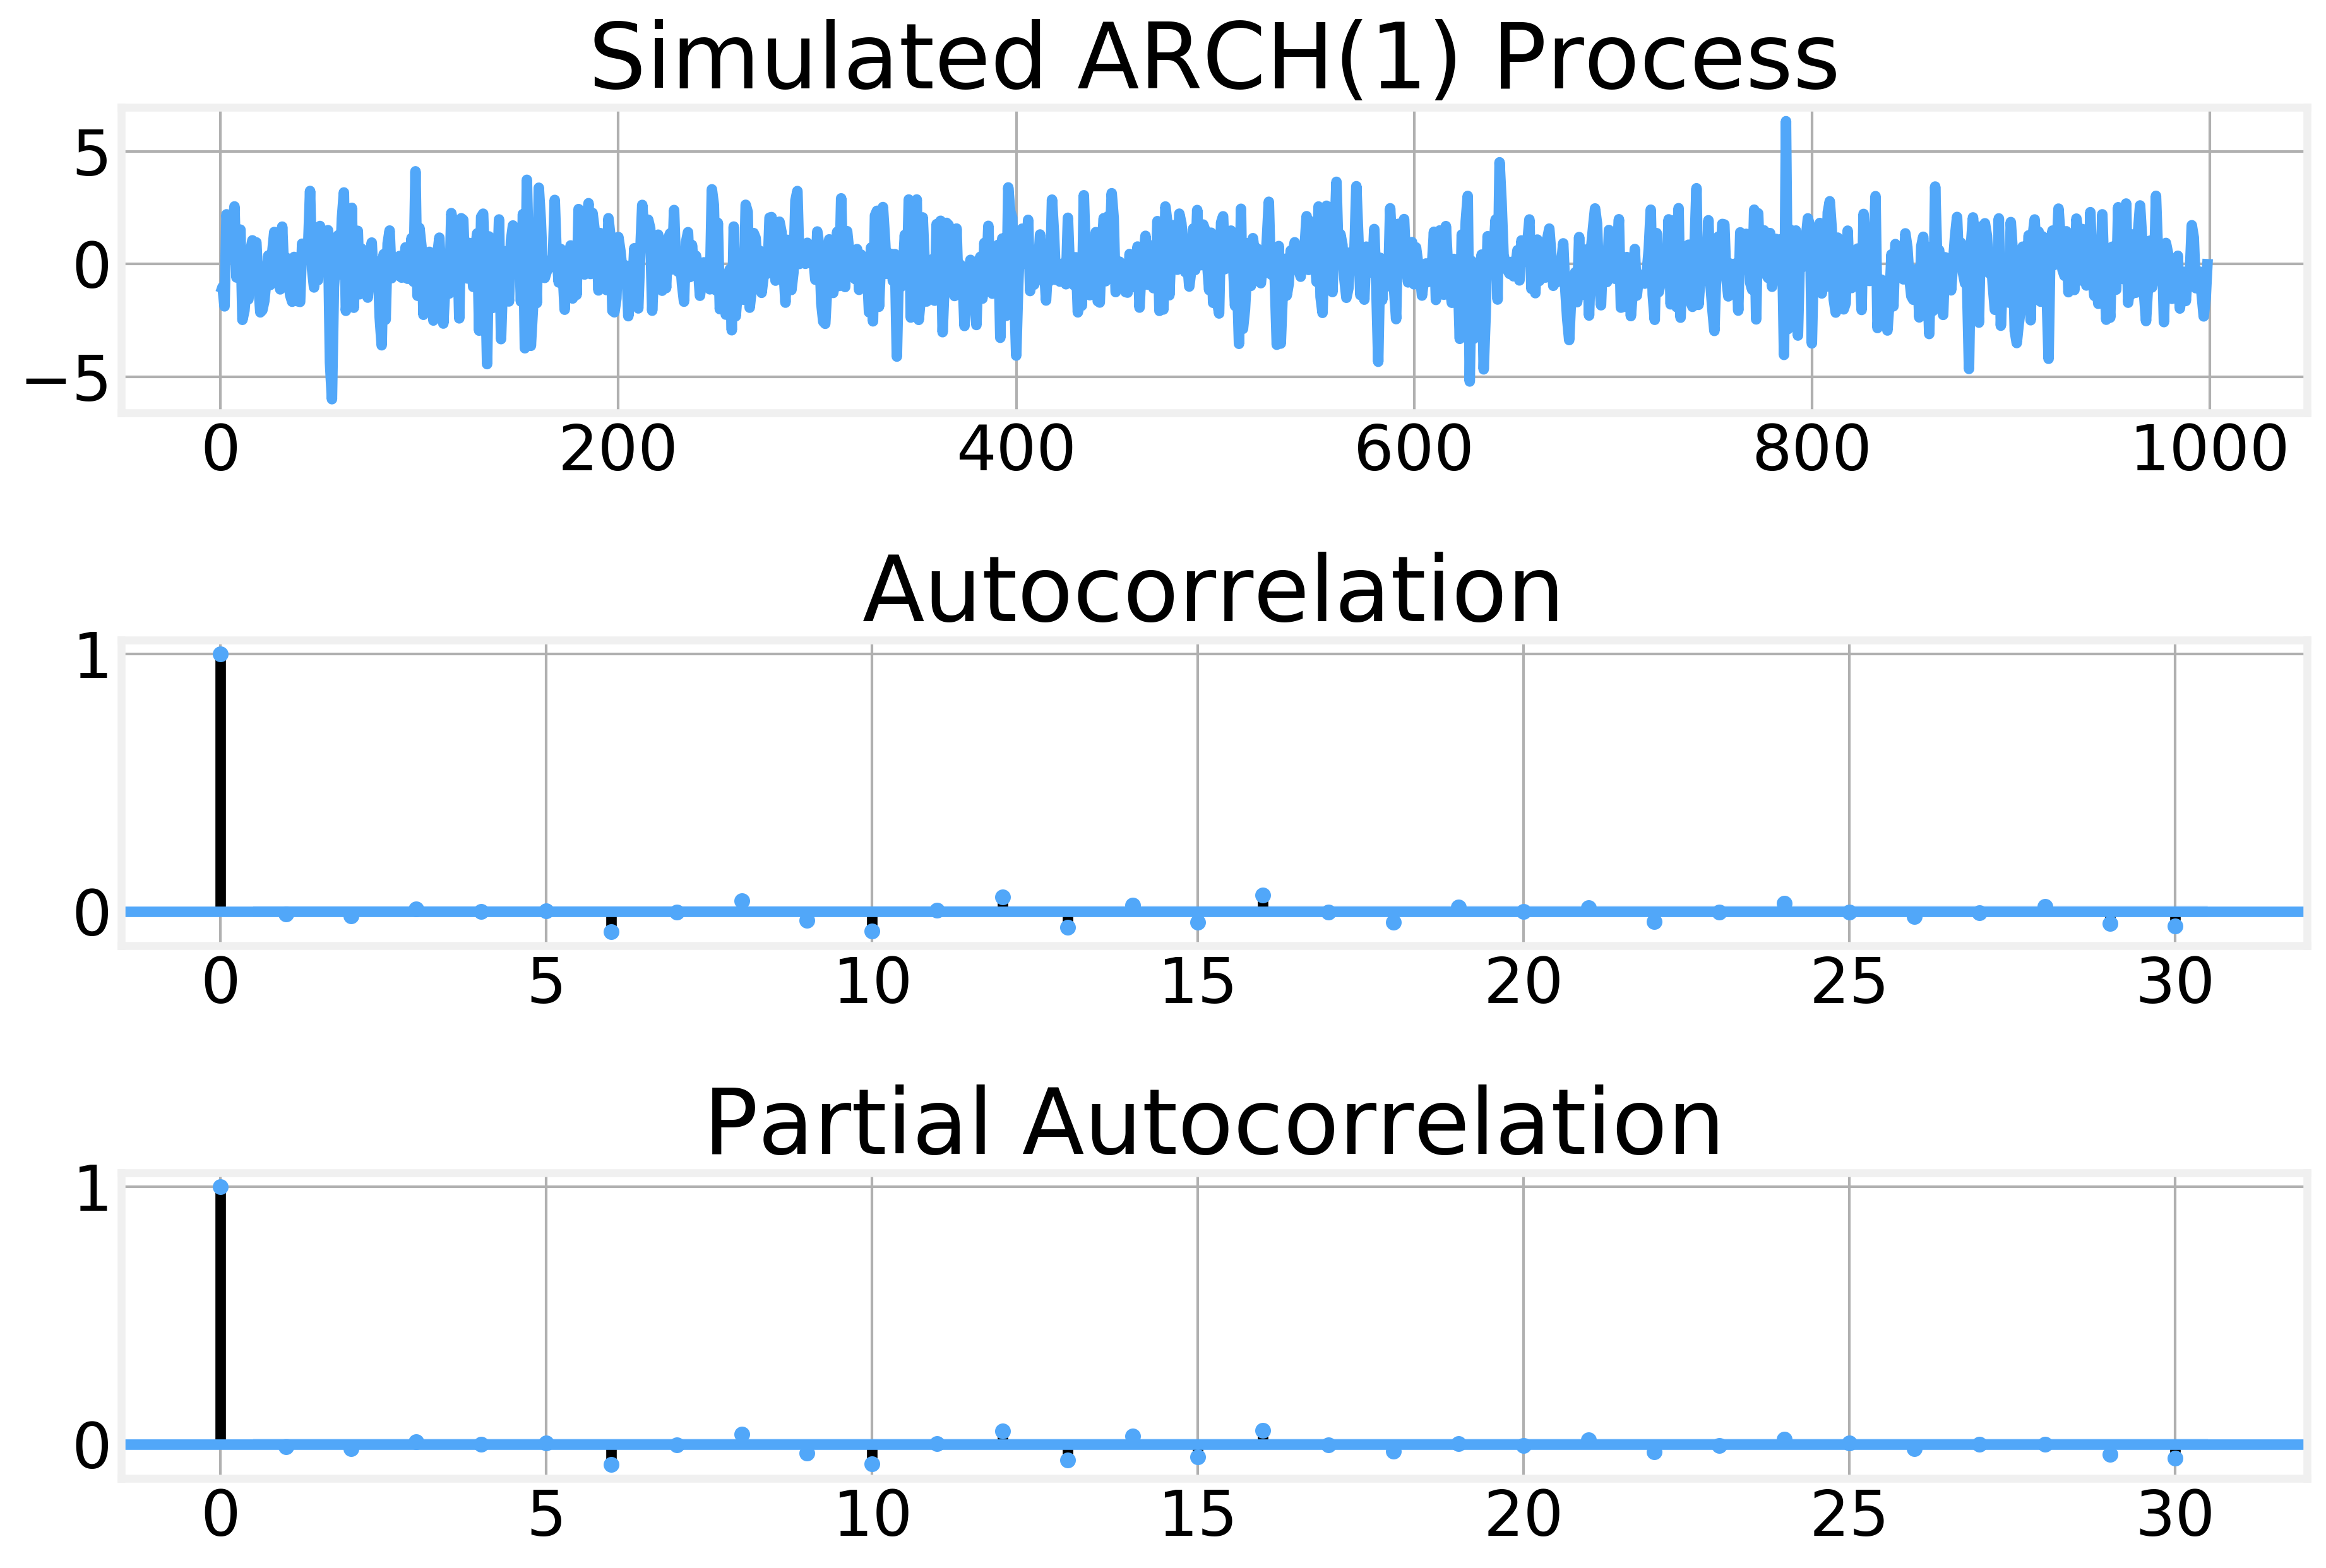

In [7]:
time_series_plot(Y, title='Simulated ARCH(1) Process')

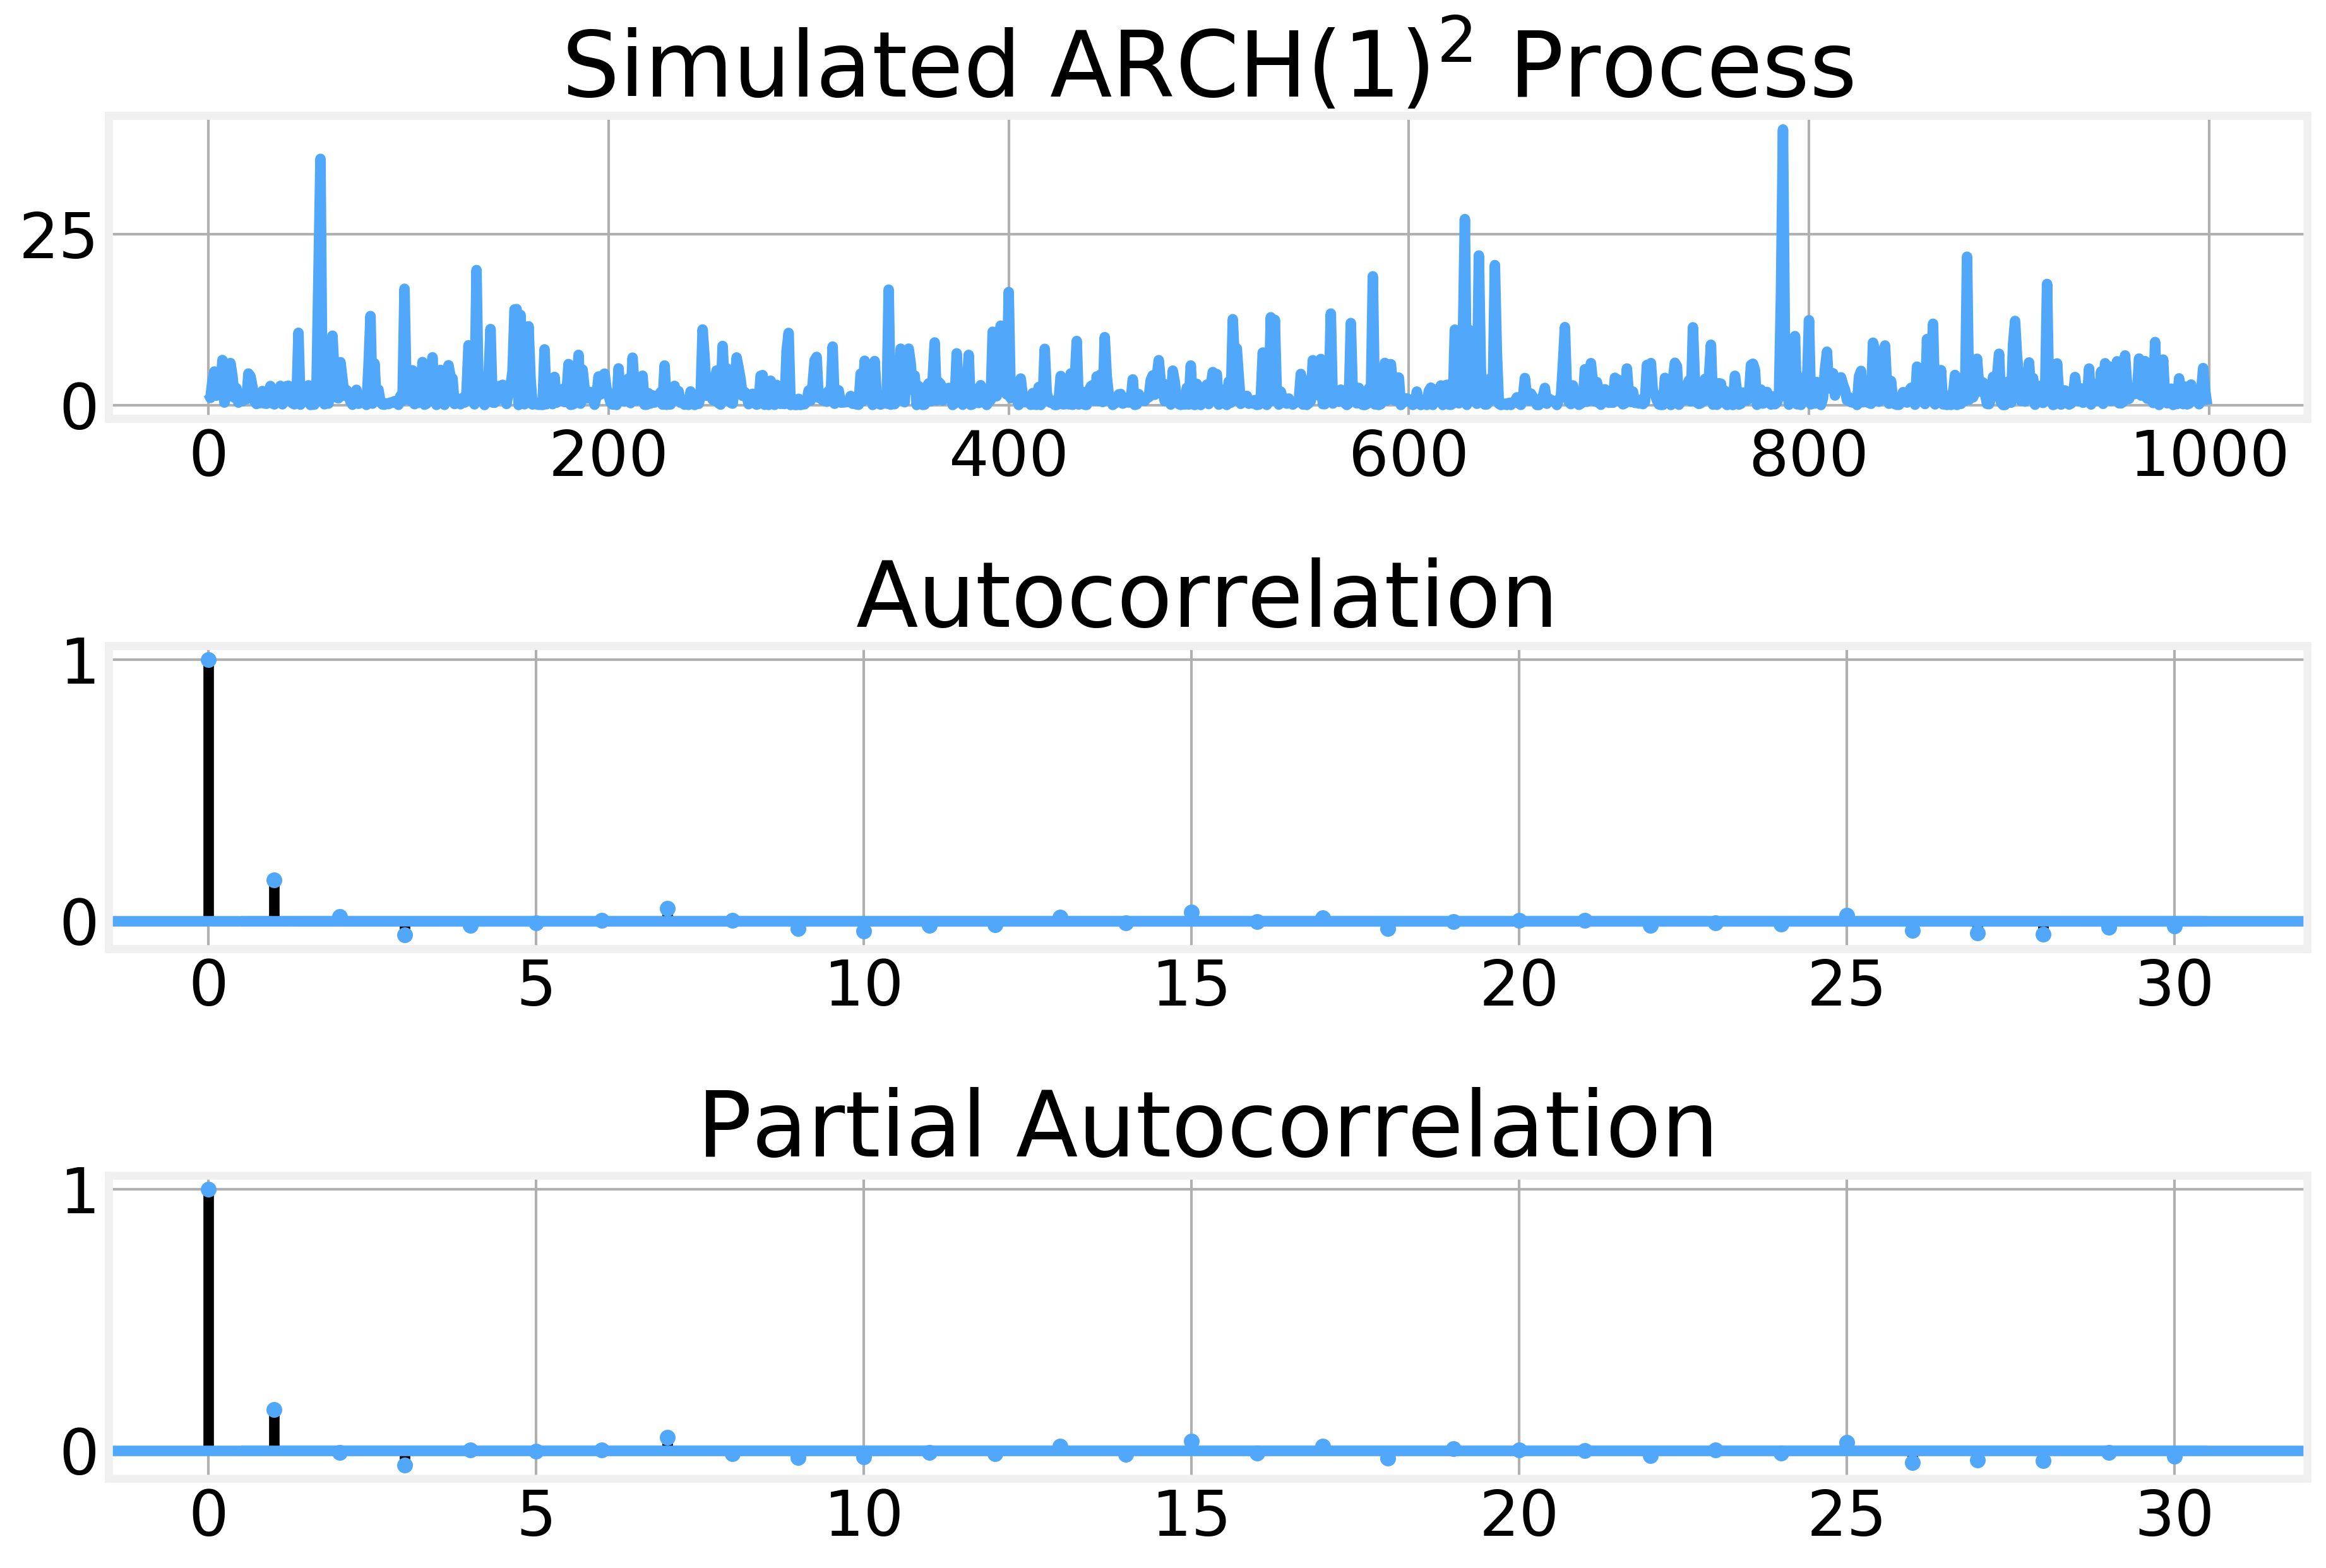

In [8]:
time_series_plot(Y**2, title=r'Simulated ARCH(1)${}^2$ Process')

## GARCH(1,1) Model

In [9]:
def GARCH(a0, a1, b1):
    n = 10000
    w = np.random.normal(size=n)
    eps = np.zeros_like(w)
    sigsq = np.zeros_like(w)

    for i in range(1, n):
        sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
        eps[i] = w[i] * np.sqrt(sigsq[i])
    
    return pd.Series(eps)

In [10]:
eps = GARCH(0.2, 0.5, 0.3)

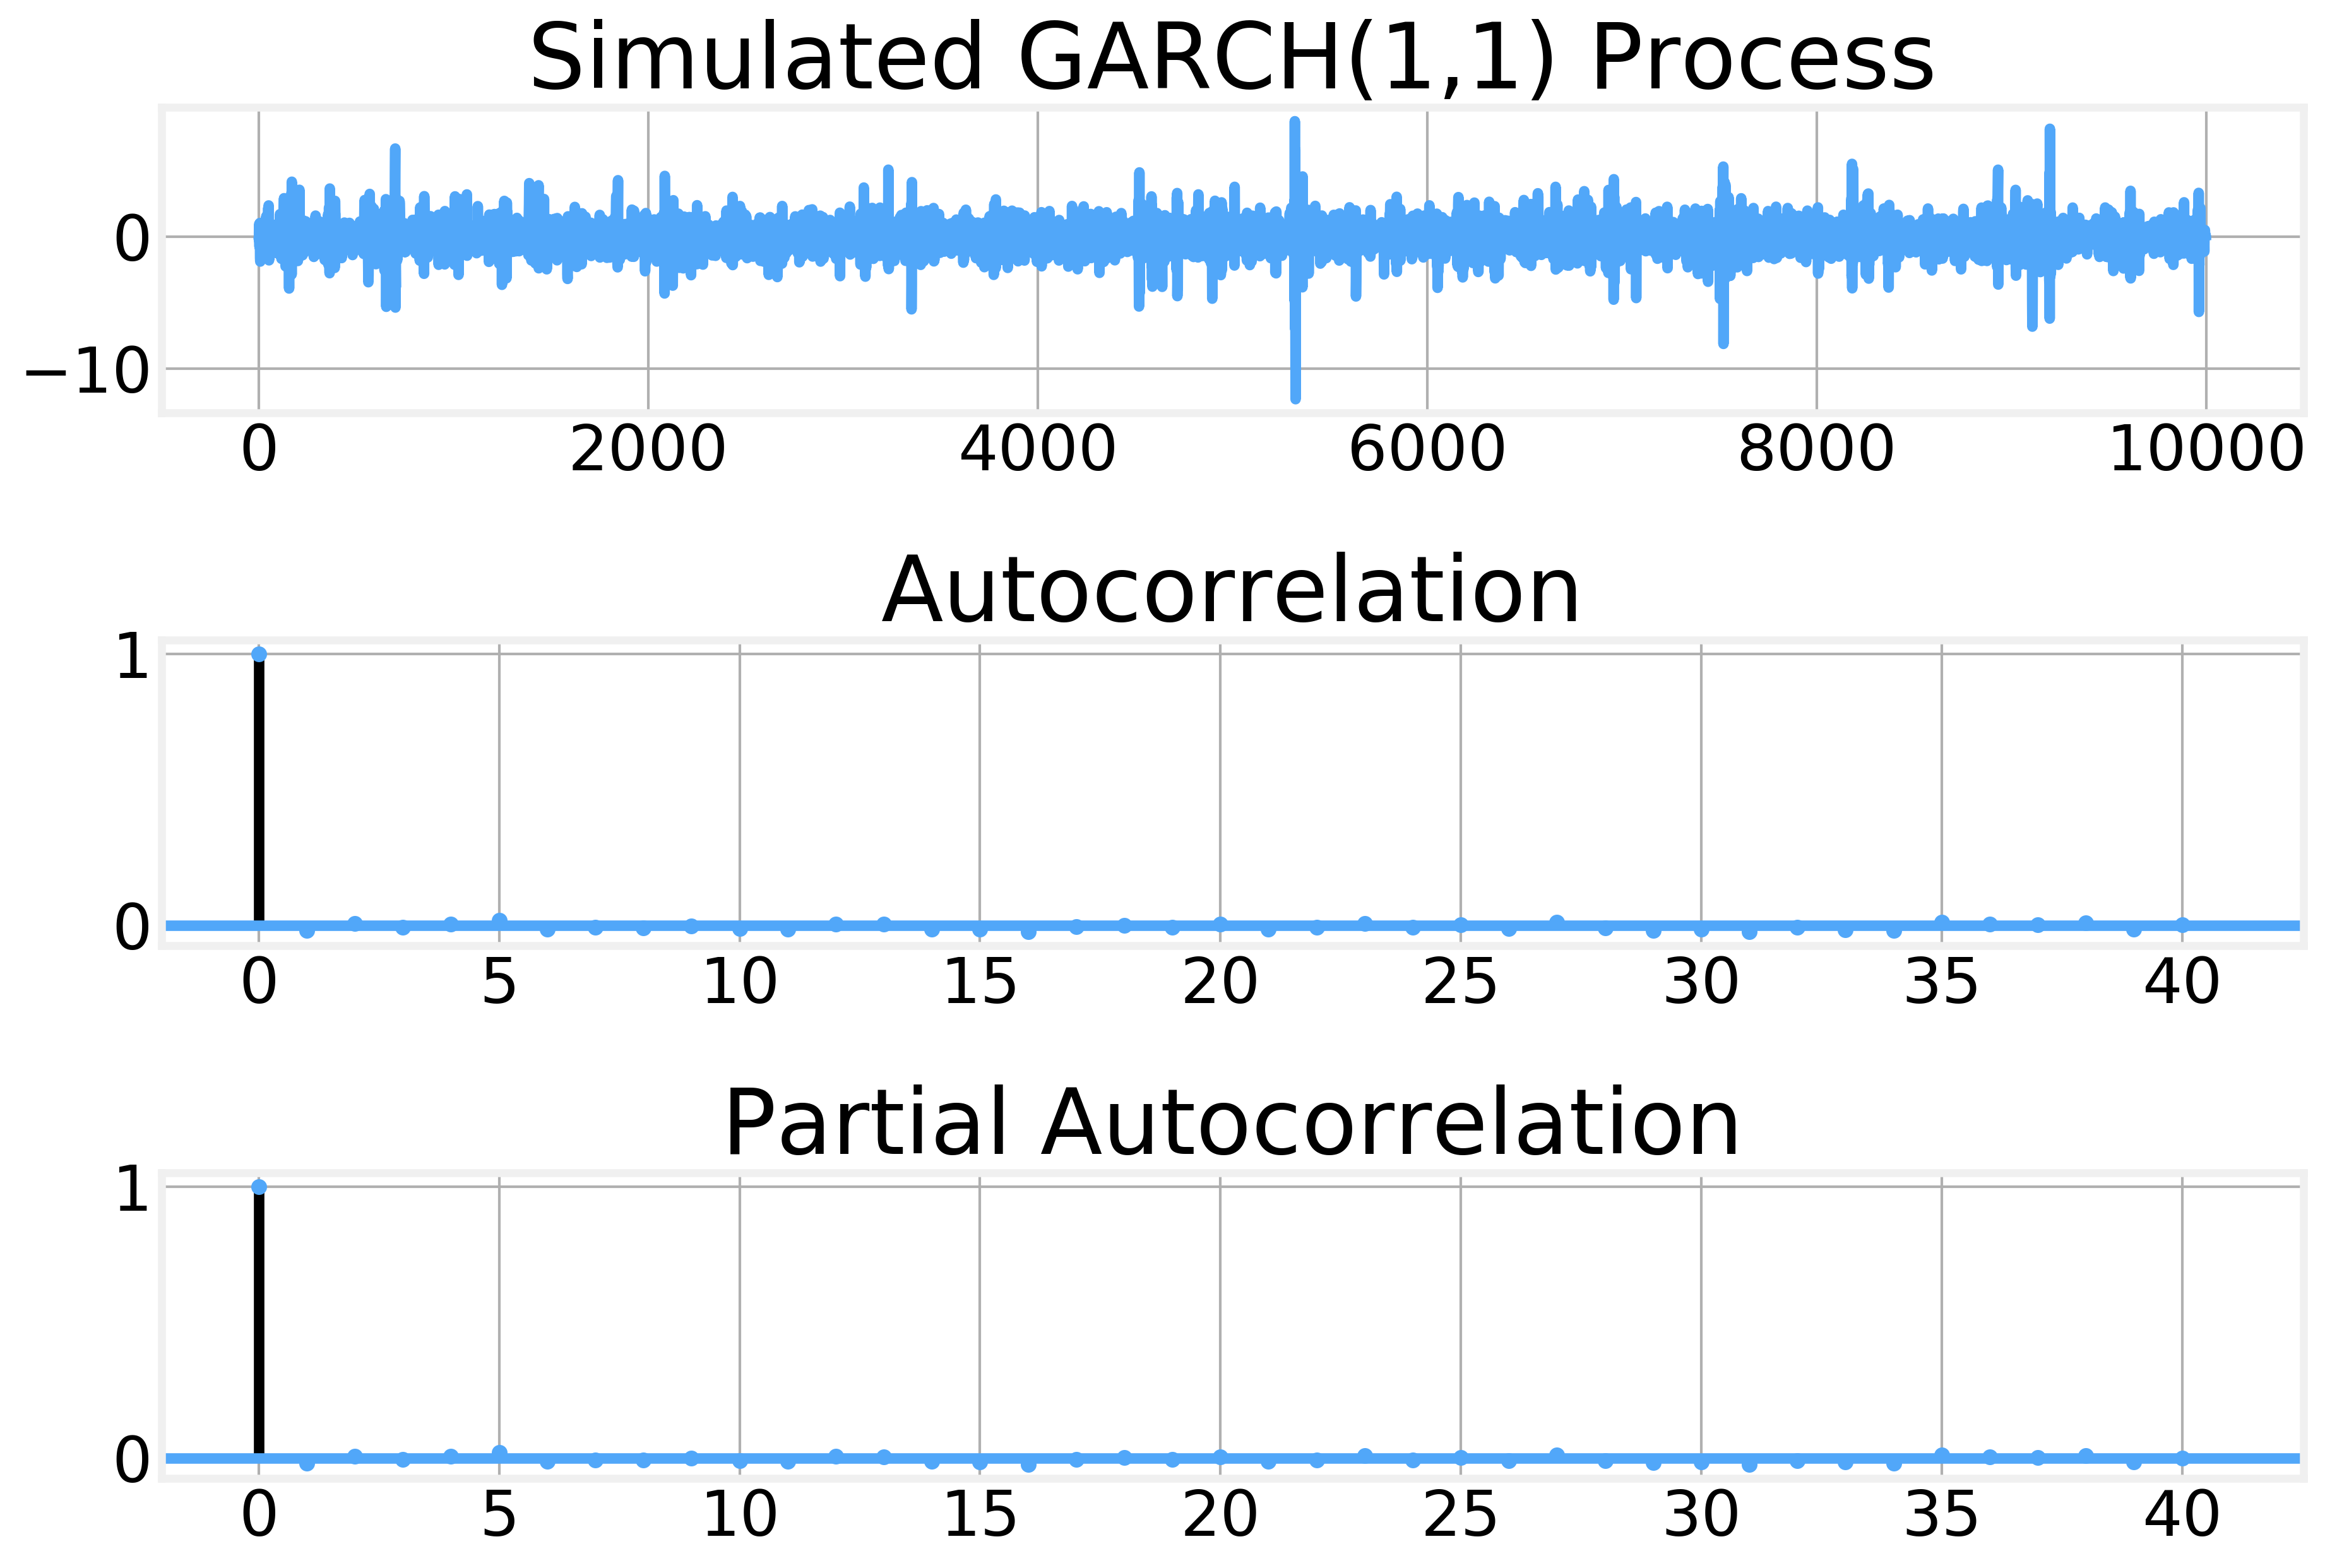

In [11]:
time_series_plot(eps, title='Simulated GARCH(1,1) Process')

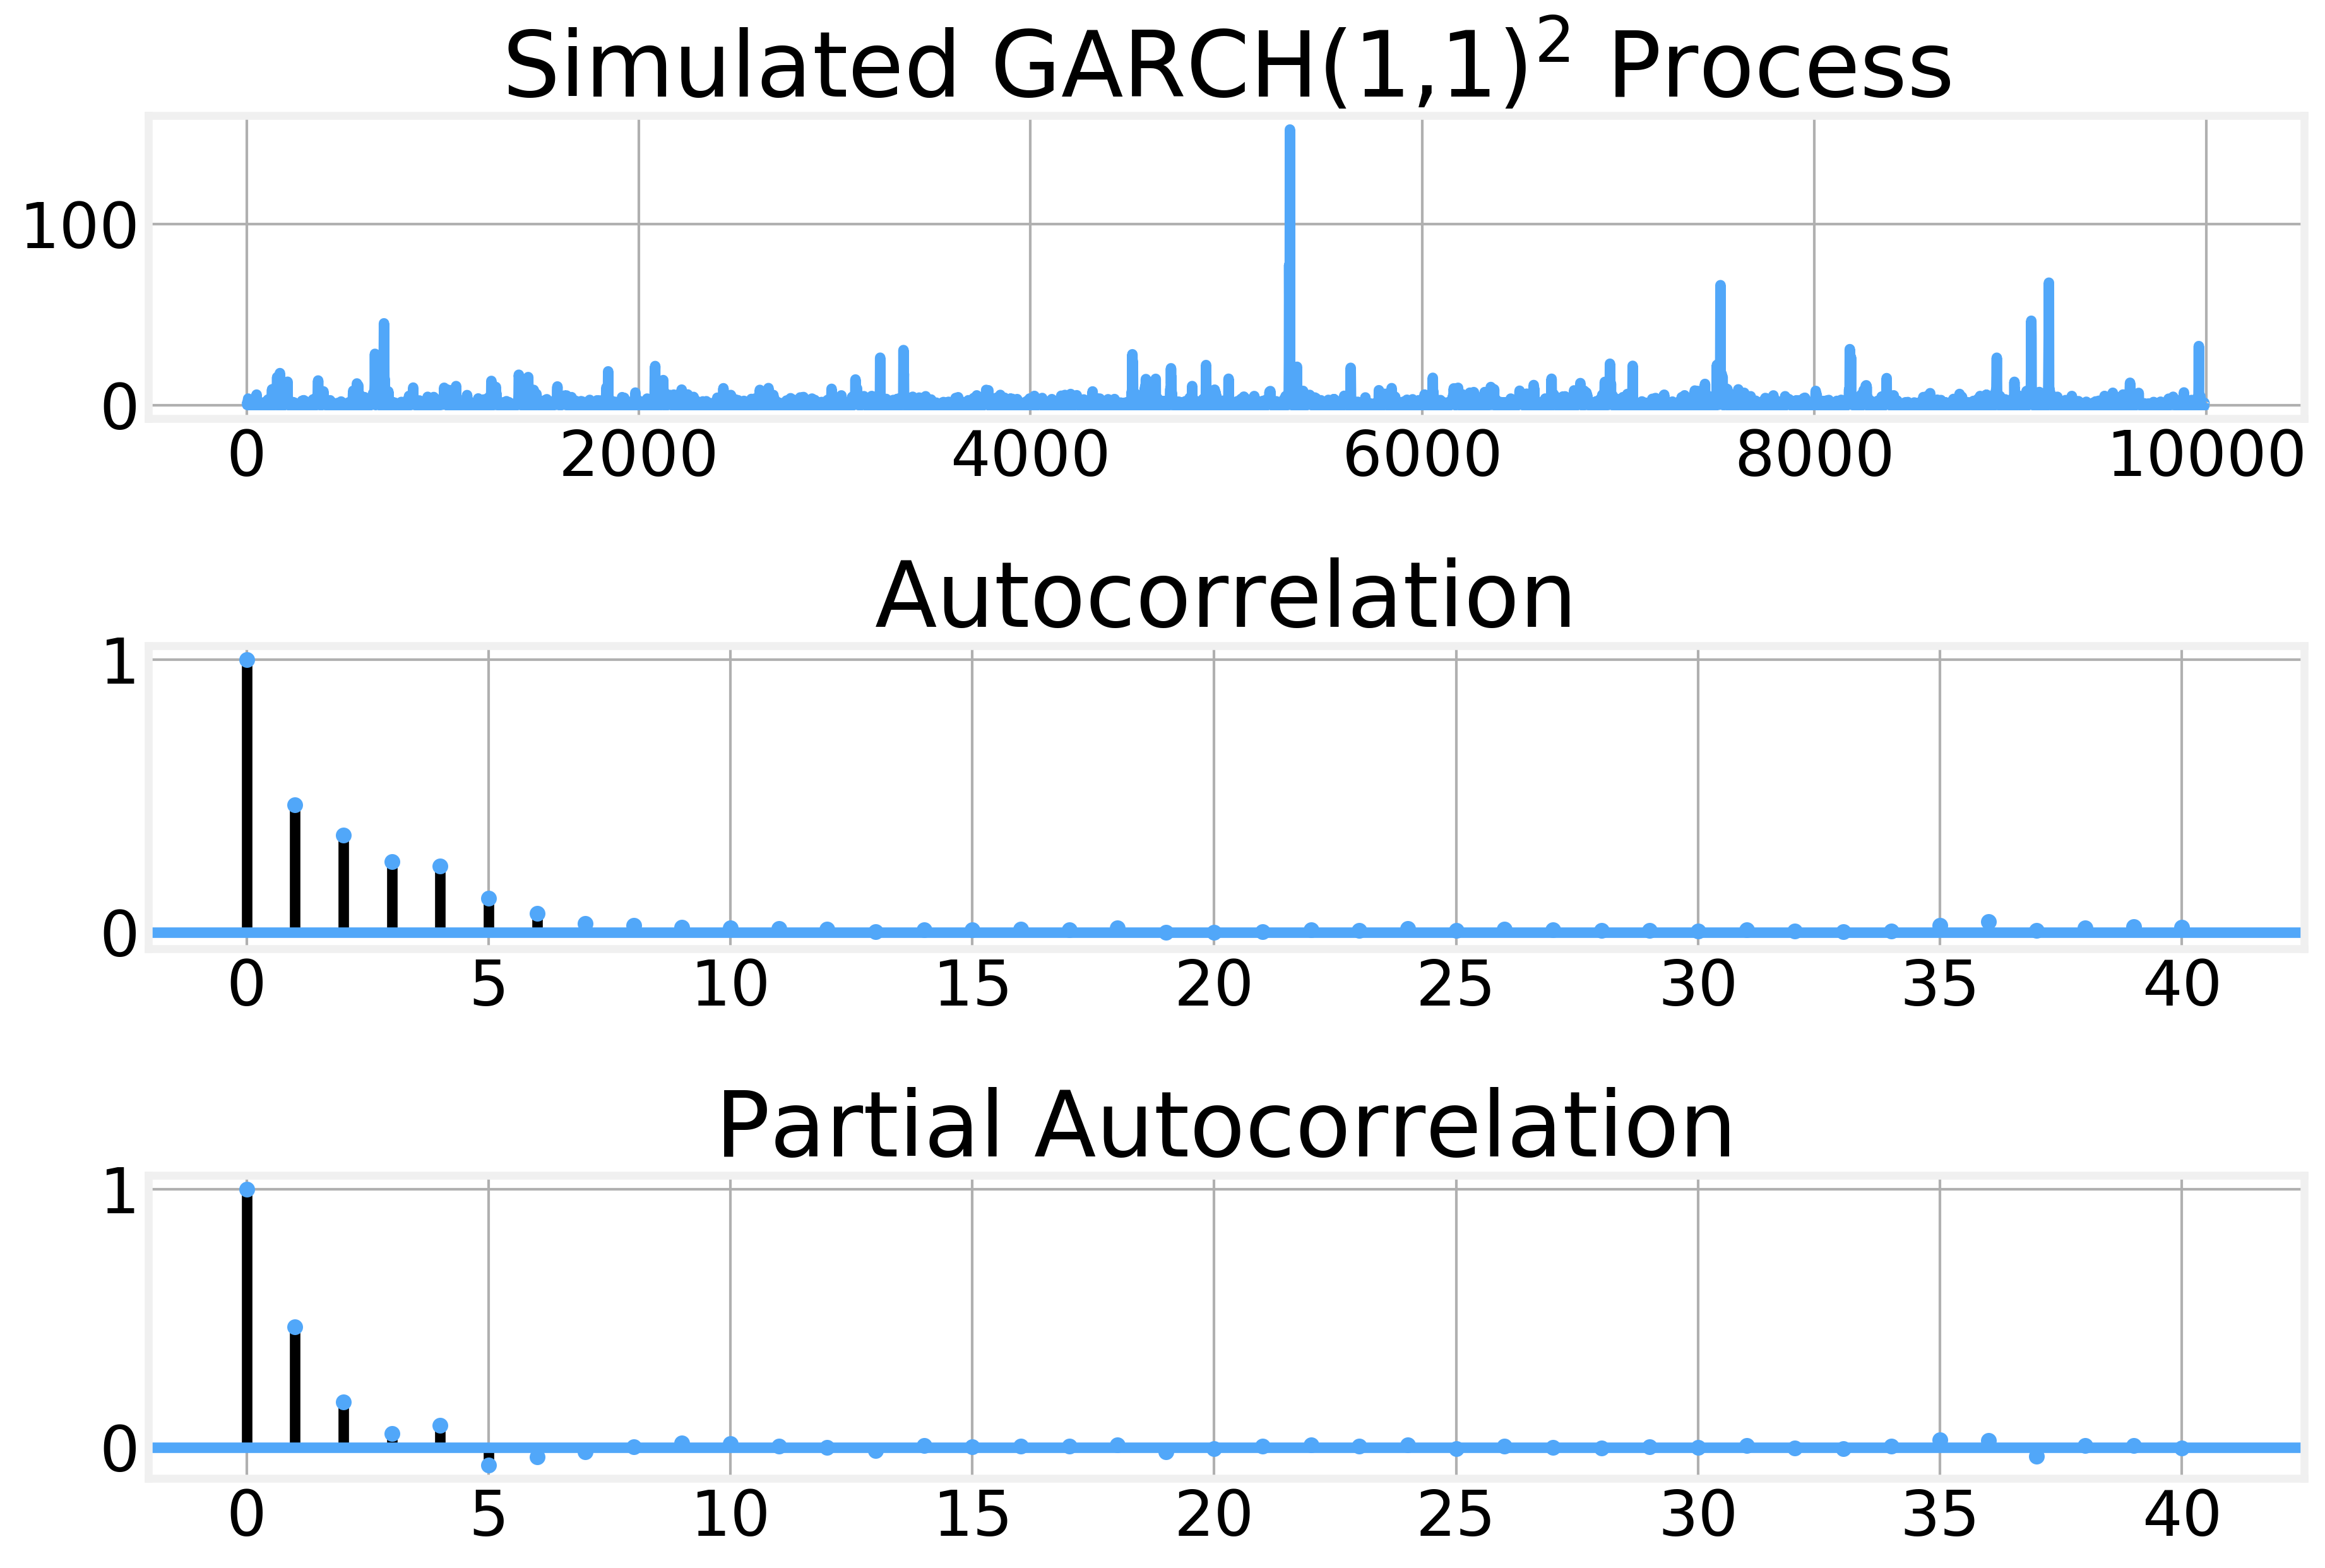

In [12]:
time_series_plot(eps**2, title=r'Simulated GARCH(1,1)${}^2$ Process')

## Fitting a model

In [13]:
DJIA = pd.read_csv('data/DJIA.csv', parse_dates=['DATE'], index_col=0, na_values='.')

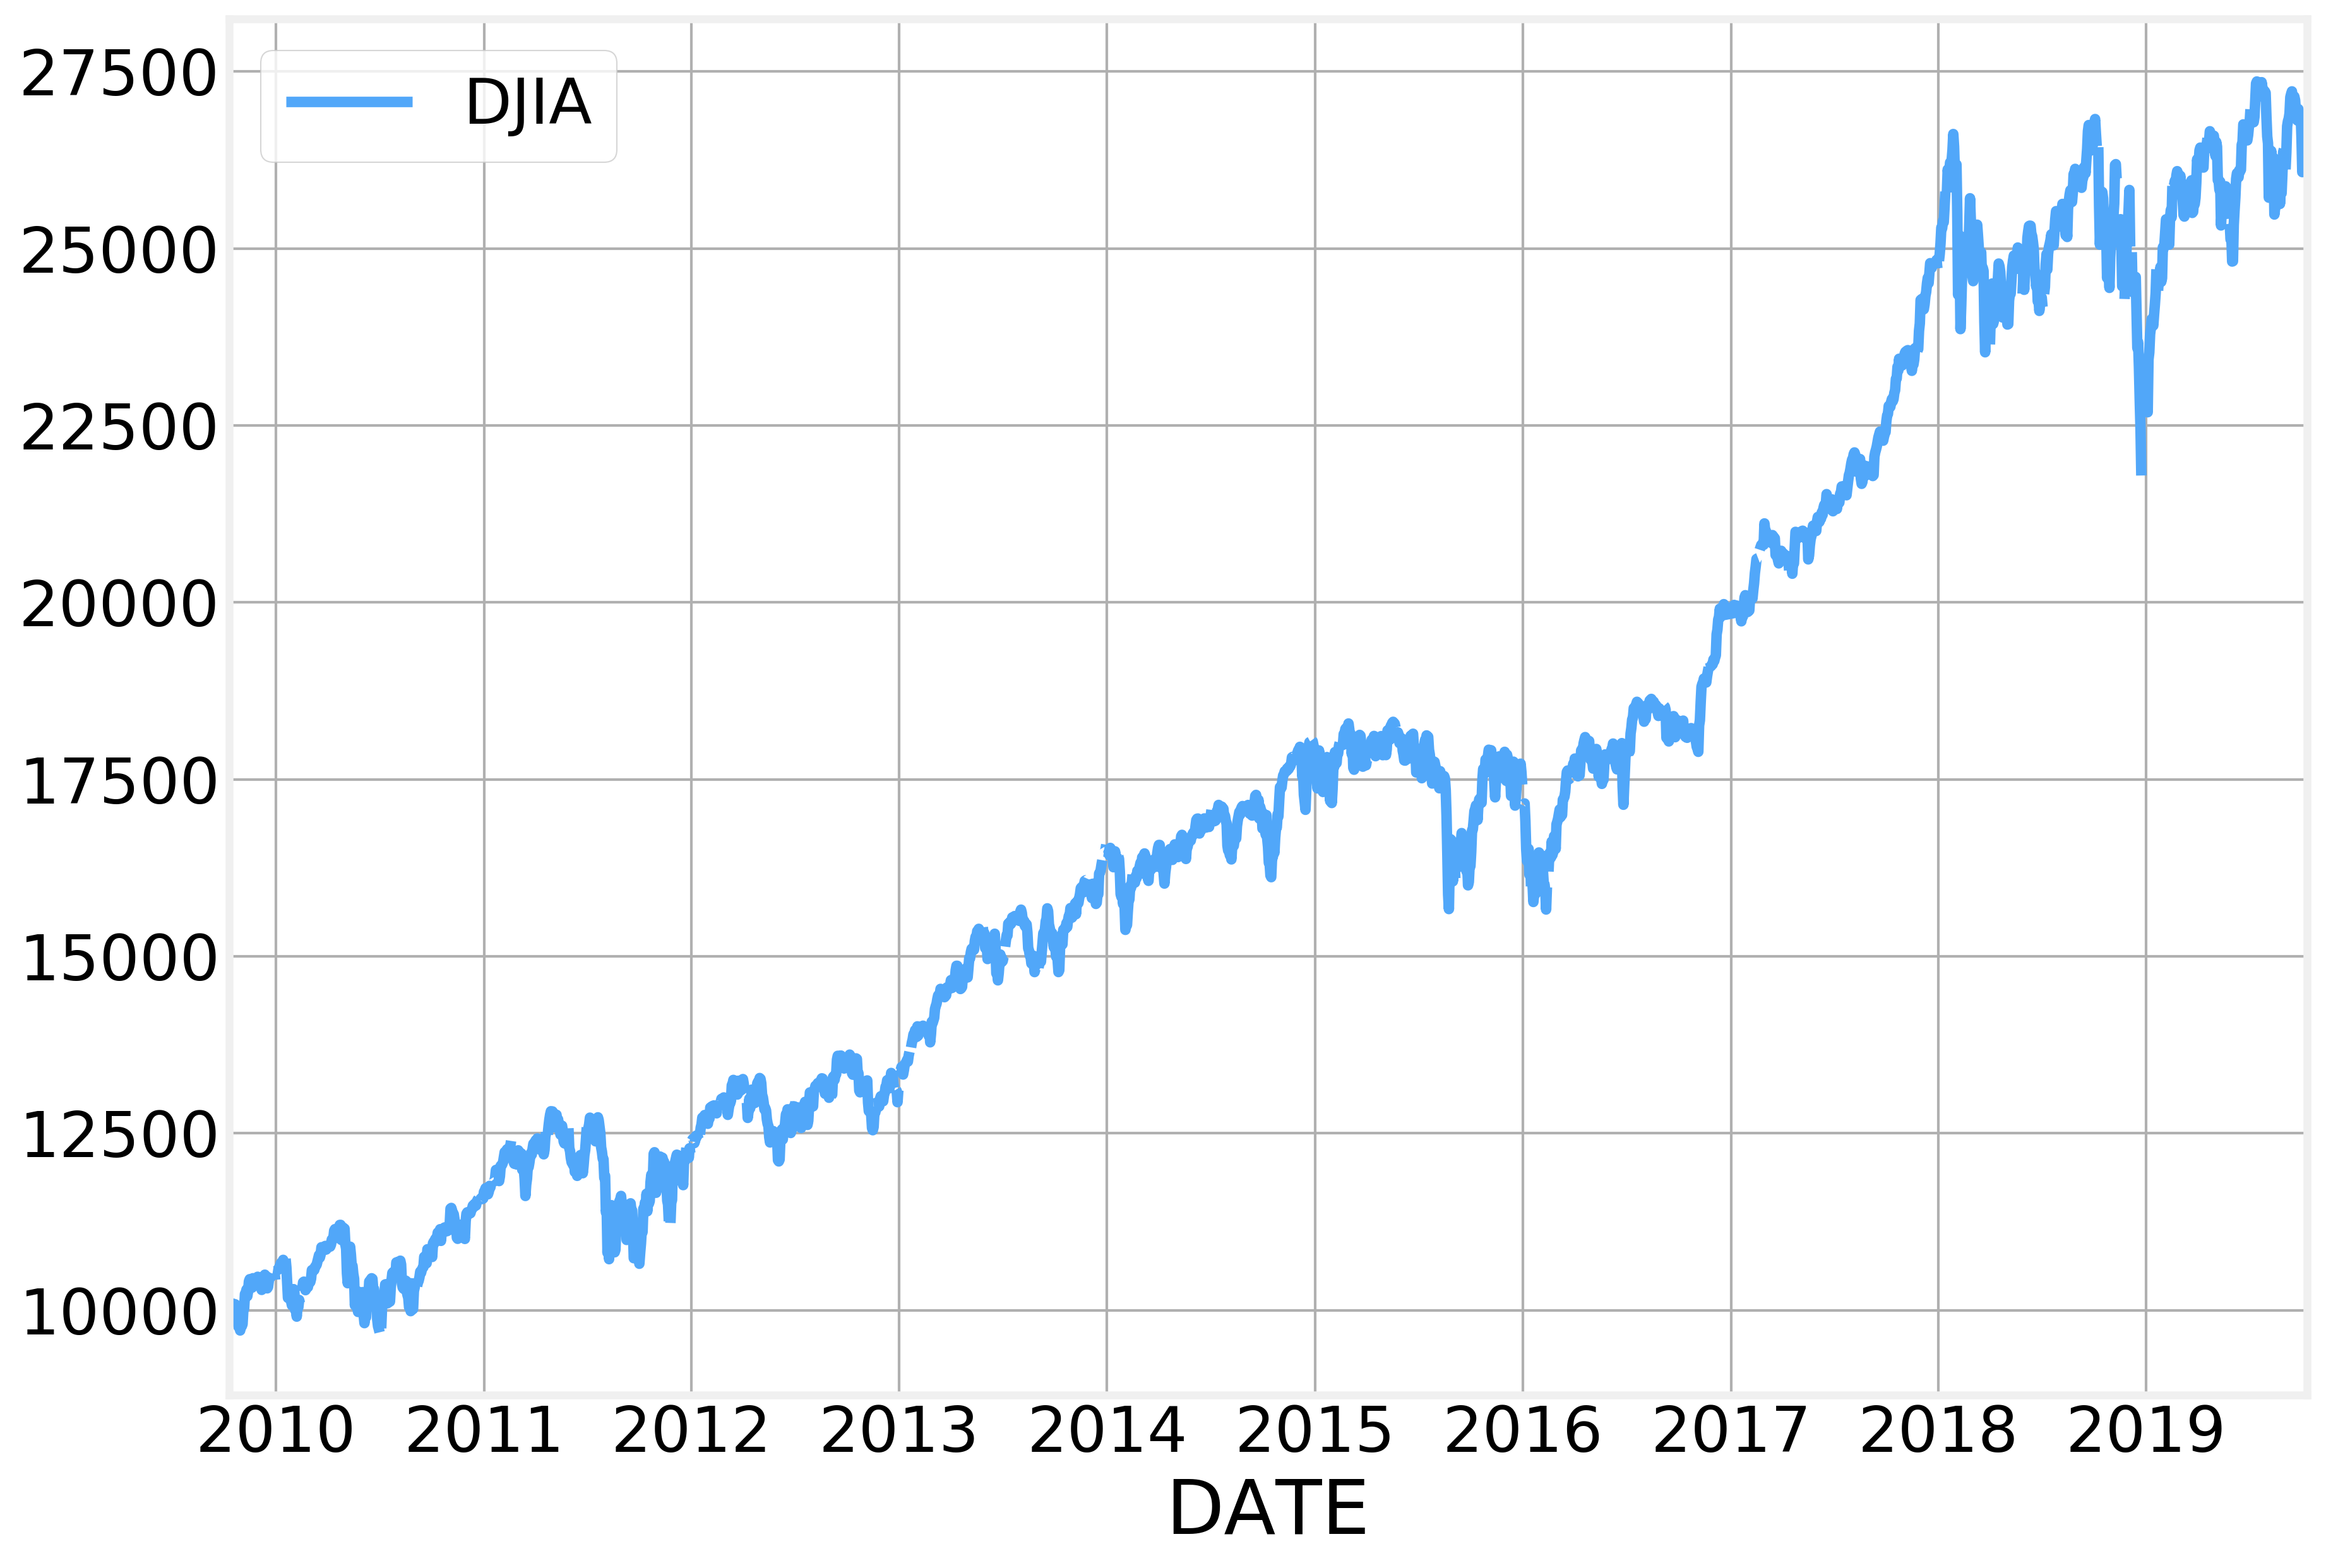

In [14]:
DJIA.plot()

Text(0, 0.5, 'DoD Return (%)')

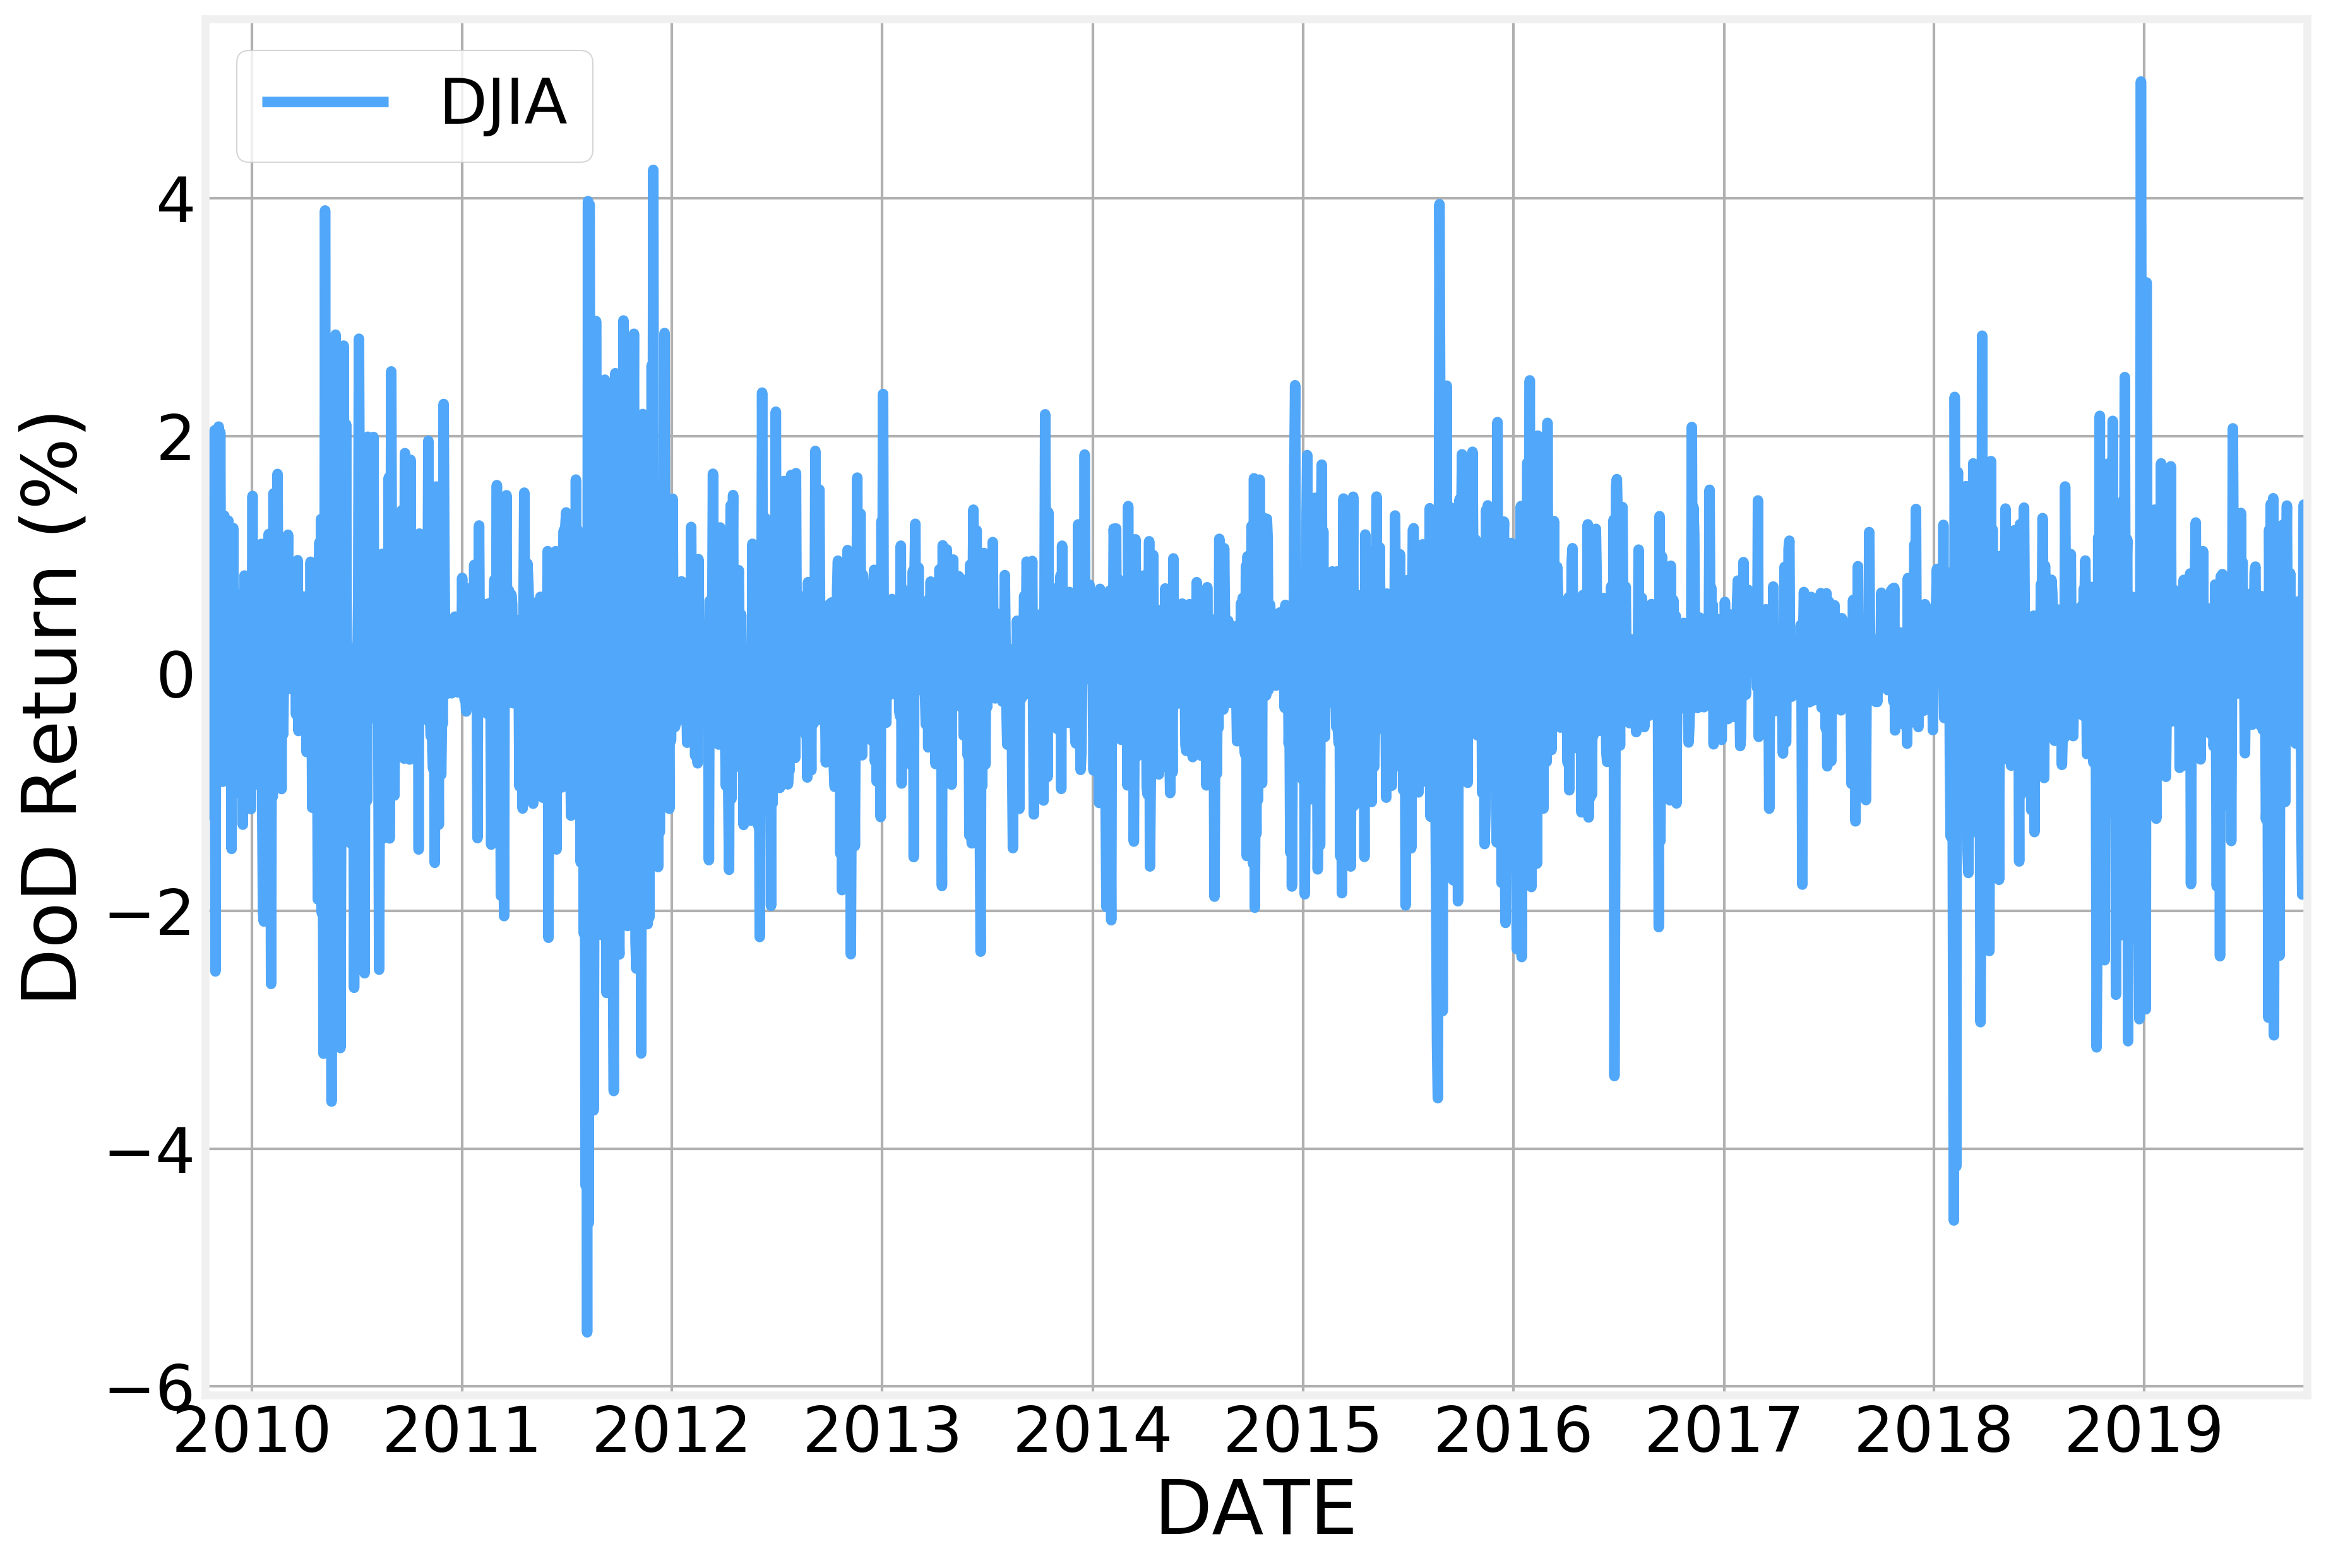

In [15]:
returns = 100 * DJIA.pct_change().dropna()
ax = returns.plot()
ax.set_ylabel('DoD Return (%)')

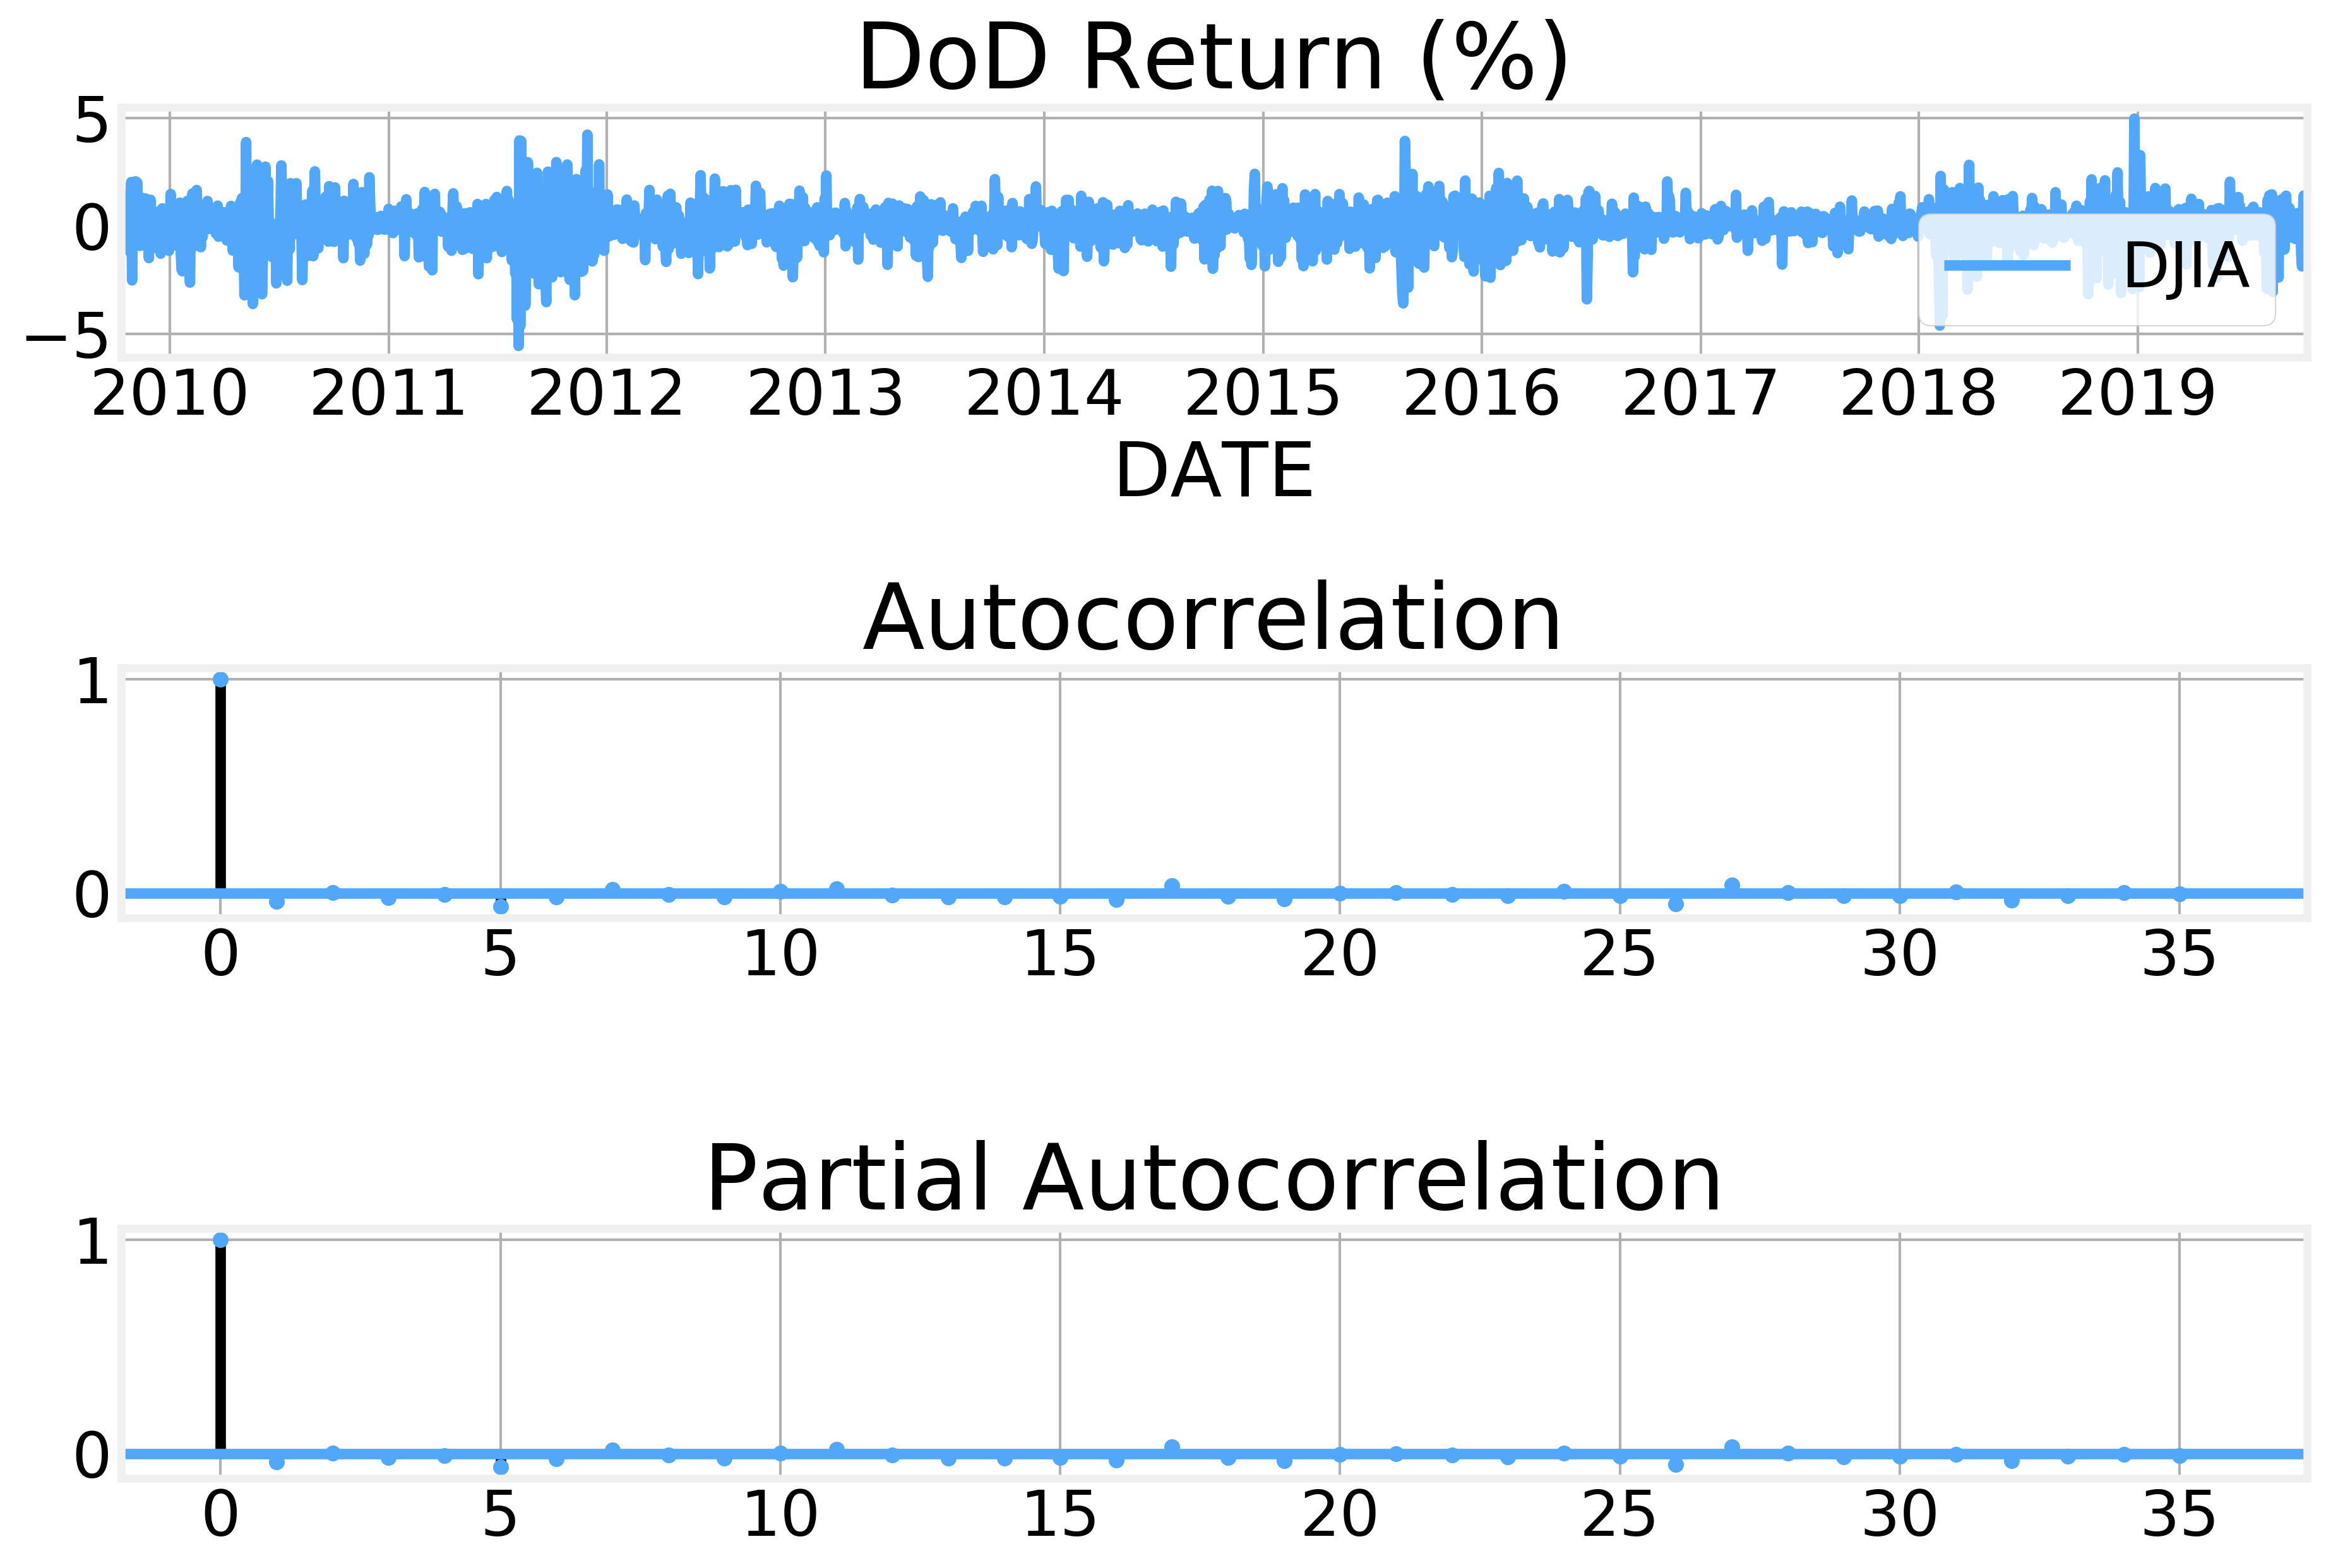

In [16]:
time_series_plot(returns, title='DoD Return (%)')

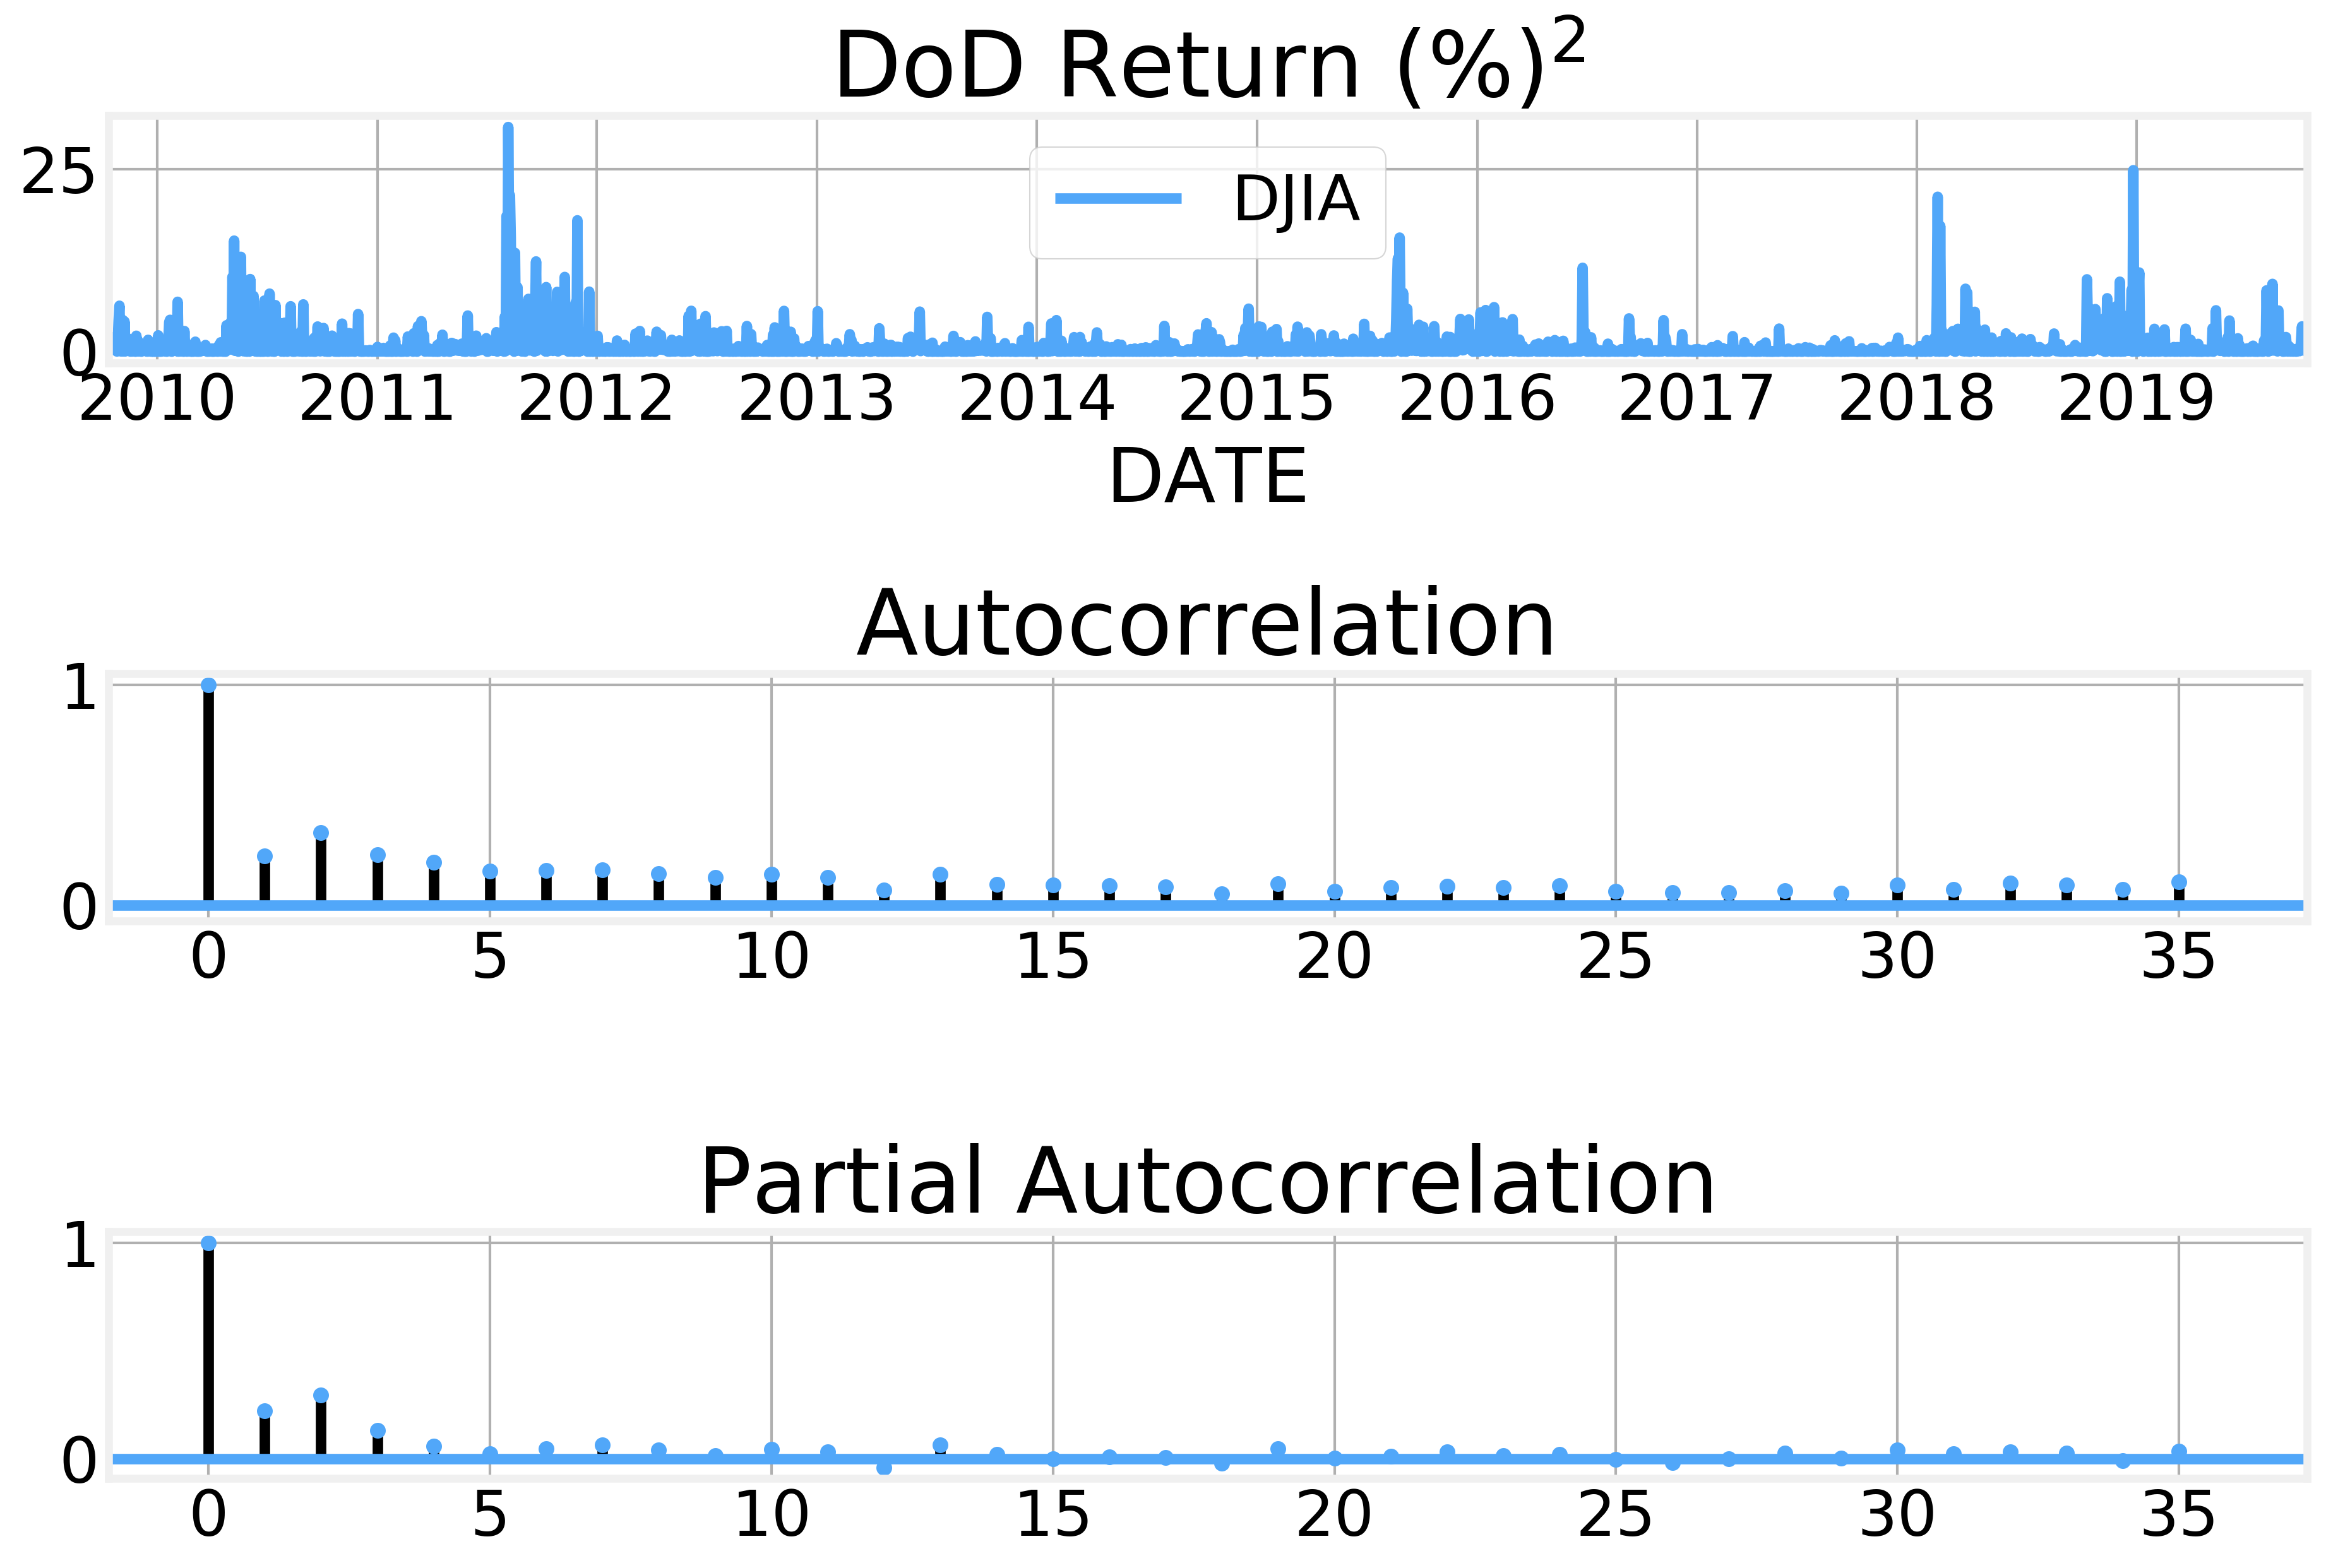

In [17]:
time_series_plot(returns**2, title=r'DoD Return (%)${}^2$')

## Train the GARCH Model

In [18]:
model = arch_model(returns, p=1, o=0, q=1)
results = model.fit();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3016.1957311225224
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3013.56851436341
Iteration:      3,   Func. Count:     26,   Neg. LLF: 3012.7171979139366
Iteration:      4,   Func. Count:     35,   Neg. LLF: 3010.260758125438
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3002.2573100150926
Iteration:      6,   Func. Count:     49,   Neg. LLF: 3002.0475423245853
Iteration:      7,   Func. Count:     55,   Neg. LLF: 3001.330248591501
Iteration:      8,   Func. Count:     61,   Neg. LLF: 3000.9345797681035
Iteration:      9,   Func. Count:     67,   Neg. LLF: 3000.9236362779066
Iteration:     10,   Func. Count:     73,   Neg. LLF: 3000.922629283118
Iteration:     11,   Func. Count:     79,   Neg. LLF: 3000.9225225942123
Iteration:     12,   Func. Count:     85,   Neg. LLF: 3000.9225186775056
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3000.9225186774793
            Iterati

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   DJIA   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3000.92
Distribution:                  Normal   AIC:                           6009.85
Method:            Maximum Likelihood   BIC:                           6033.31
                                        No. Observations:                 2608
Date:                Wed, Aug 12 2020   Df Residuals:                     2604
Time:                        07:38:41   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0744  1.327e-02      5.608  2.043e-08 [4.840e-02,  0.100]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0318  6.646e-03      4.780  1.749e-06 [1.875e-02,4.480e-02]
alpha[1]       0.1587  2.316e-02      6.851  7.310e-12     [  0.113,  0.204]
beta[1]        0.8033  2.280e-02     35.232 6.527e-272     [  0.759,  0.848]
============================================================================

Covariance estimator: robust
"""

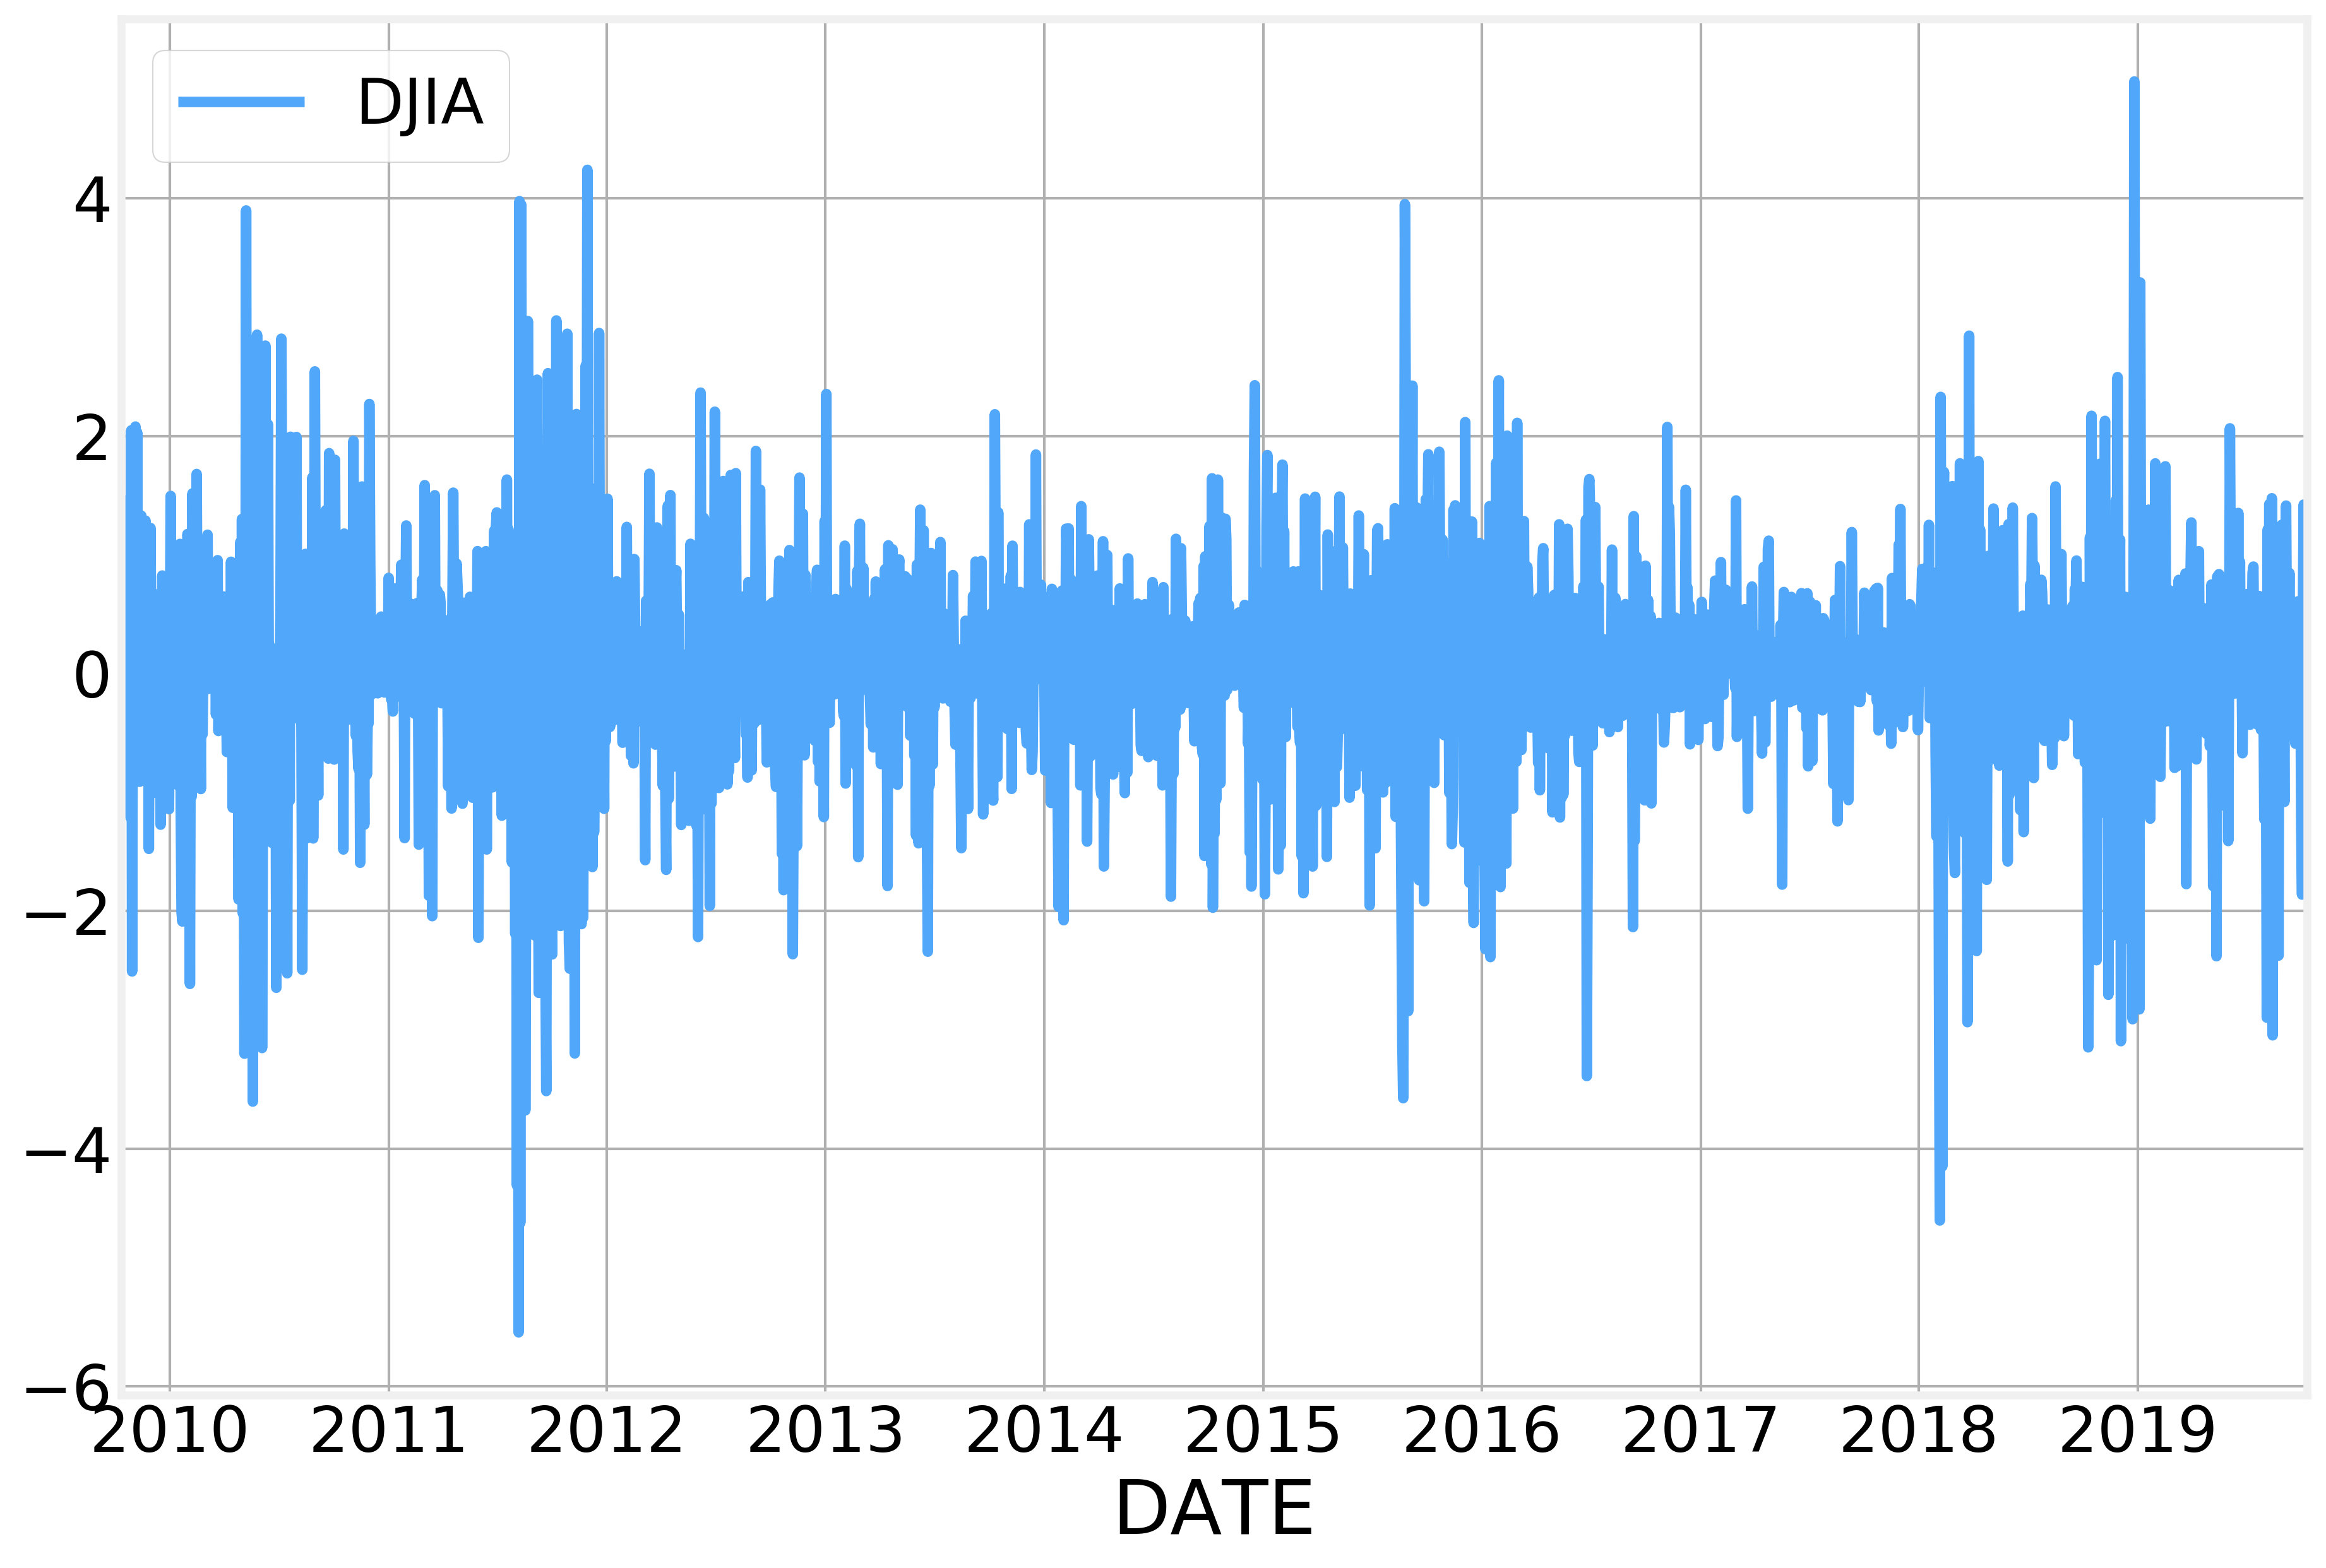

In [20]:
ax = returns.plot()

Simulate some values based on our model

In [21]:
simulated =  model.simulate(params=results.params, nobs=2608)['data']
simulated.index = returns.index

And plot them

Text(0, 0.5, 'DoD Returns (%)')

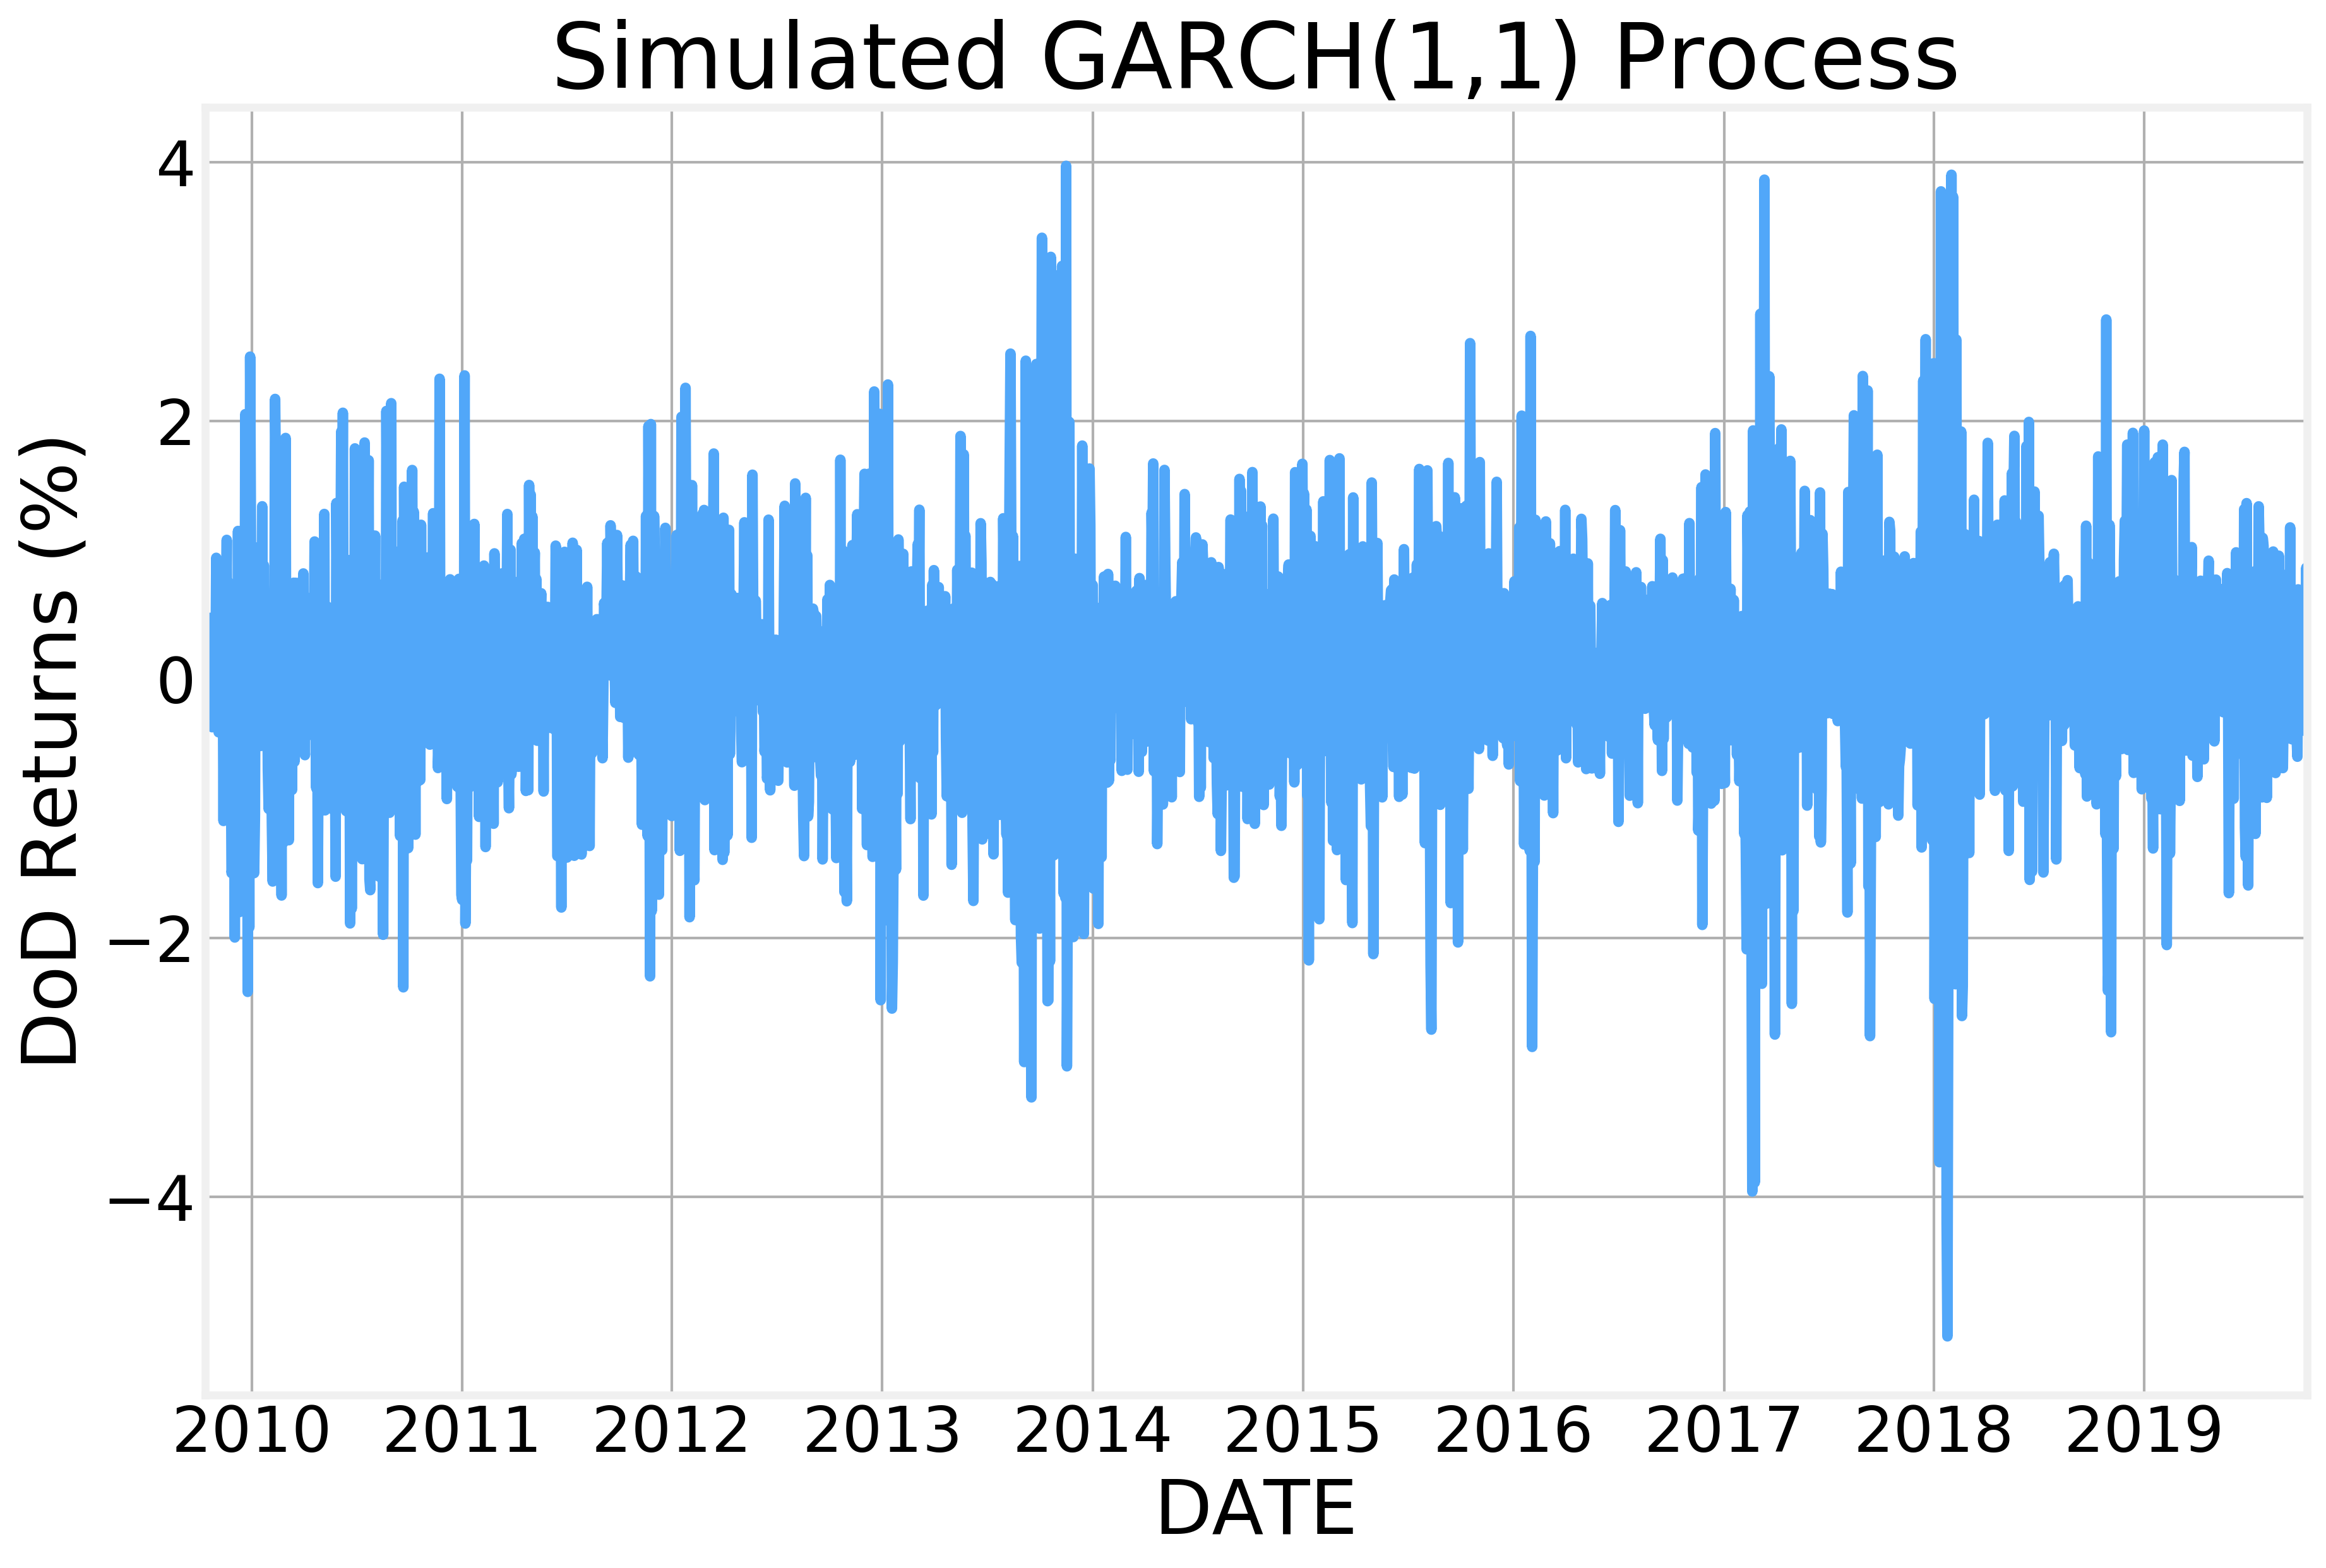

In [22]:
ax = simulated.plot()
ax.set_title('Simulated GARCH(1,1) Process')
ax.set_ylabel('DoD Returns (%)')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>